In [1]:
import warnings
import os
import sys

# --- 1. Standard Python Warnings ---
# Filter out common warning categories explicitly
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- 2. Specific Library Warnings (e.g., Scikit-learn) ---
# Suppress warnings from scikit-learn's specific modules if they are particularly noisy
try:
    from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    warnings.filterwarnings('ignore', category=DataConversionWarning)
    # You can also target specific module paths if a warning originates there
    # warnings.filterwarnings('ignore', module='sklearn.linear_model._logistic')
except ImportError:
    pass # sklearn might not be imported yet, or not installed

# --- 3. For Parallel Processing (n_jobs > 1 or n_jobs = -1) ---
# This is often the culprit for persistent warnings, especially with sklearn.
# It sets an environment variable that child processes might inherit.
os.environ["PYTHONWARNINGS"] = "ignore"

# --- 4. Advanced/Less Common Suppression (if still seeing issues) ---
# Sometimes, warnings might be generated very early during interpreter startup
# or by low-level C extensions. This can catch some of those.
if not sys.warnoptions:
    warnings.simplefilter("ignore")

print("All common warnings suppressed for this notebook session.")

All common warnings suppressed for this notebook session.


# CICIDS2017 ML Pipeline for Binary Class Classification

# Business Goal
The primary business goal of this project is to establish a highly effective and robust automated system for real-time detection of network intrusions and malicious activities, thereby significantly mitigating cybersecurity risks, safeguarding critical assets, and ensuring operational continuity.

### Key Objectives to Achieve this Goal:

Proactive Risk Mitigation: Aim is to achieve extremely high F1-scores, the pipeline aims to identify potential threats with exceptional accuracy and minimal false negatives, allowing for swift containment before significant damage or disruption occurs.

Minimize Security Incident Impact: Aim is to achieve extremely high ROC AUC and Average Precision for the positive class, to ensure that the system can reliably distinguish malicious from benign traffic across various thresholds, leading to highly confident alerts that enable rapid and appropriate incident response, reducing the time and resources spent on investigating benign events.

Optimize Security Operations: Automating the accurate detection of attacks reduces the manual burden on security analysts, allowing them to focus on complex threat analysis and strategic defense, rather than sifting through large volumes of benign traffic. This improves the overall efficiency and effectiveness of the security operations center (SOC).

Strengthen Overall Cybersecurity Posture: Implementing this highly performant binary classification pipeline fortifies the organization's defense mechanisms against a broad spectrum of network-based threats, leading to increased trust in the network's integrity and resilience.

## 1. Data Loading
This section covers loading the dataset and initial data preparation steps, including stratified sampling to handle large datasets. This section initializes the p by setting up reproducibility, loading a stratified sample of the CICIDS2017 dataset for binary classification, and confirming its label structure. It then prepares and saves a LabelEncoder and establishes a checkpoint directory, ensuring consistent data handling and model saving across subsequent stages.

### Note
Uncomment below cell before running the pipeline in Colab.

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
import pandas as pd
import numpy as np
import random
import os
import pickle # To save/load the LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay,
    PrecisionRecallDisplay, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from imblearn.over_sampling import SMOTE

import shap
import joblib # For saving models

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Define a function to set all seeds for reproducibility
def set_all_seeds(seed):
    """Sets the seed for reproducibility across different libraries."""
    random.seed(seed) # Python's built-in random module
    np.random.seed(seed) # Numpy
    torch.manual_seed(seed) # PyTorch CPU
    if torch.cuda.is_available(): # PyTorch CUDA (GPU)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For multi-GPU setups
        # Ensure cudnn is deterministic for reproducibility
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # Set to False for reproducibility, True for speed

# Set your desired seed
SEED = 42 # Or any other integer
set_all_seeds(SEED)

print(f"All random seeds set to {SEED}")

# --- 1. Data Loading and Initial Sampling ---

# Load cleaned dataset (assuming 'label' column is already 0 for BENIGN, 1 for ATTACK)
df = pd.read_csv('CICIDS2017_cleaned.csv')
# If using Google Colab with Drive, uncomment the line below and ensure Drive is mounted:
# df = pd.read_csv('/content/drive/My Drive/CICIDS2017_cleaned.csv')

# Define the ratio of data you want to use (e.g., 0.005 for 0.5%)
subset_ratio = 0.1 # 0.1

# Perform stratified sampling manually
# This groups by 'label' (which should be 0 or 1) and samples 'frac' from each group
df_subset = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=subset_ratio, random_state=SEED))

print(f"Number of rows and columns in the Original dataset: {df.shape}")
print(f"Number of rows and columns in the Subset dataset: (approx {subset_ratio*100}%): {df_subset.shape}")

# Define X (features) and y (binary numerical labels 0/1) from the subset
X = df_subset.drop('label', axis=1)
y = df_subset['label'] # 'y' should now contain 0s and 1s

# --- 2. Confirming Binary Labels and Encoding for Consistency ---
# This section is streamlined for binary classification.
# We're confirming 'y' is 0 or 1, and setting up a LabelEncoder for consistent mapping to string names.

final_label_encoder = LabelEncoder()
# Explicitly set the classes to ensure 0 maps to 'BENIGN' and 1 maps to 'ATTACK'
# Using dtype=object ensures it handles string types correctly.
final_label_encoder.classes_ = np.array(['BENIGN', 'ATTACK'], dtype=object)

# Basic validation that 'y' contains only 0s and 1s
if not y.isin([0, 1]).all():
    raise ValueError("The 'label' column in your subset is not strictly binary (expected 0 or 1). "
                     "Please ensure the input CSV is correctly preprocessed for binary classification.")


print("\nBinary label distribution in the sampled subset:")
# Use the correctly configured encoder for inverse transformation to get string labels for display
# Ensure index alignment when creating the Series from the inverse_transform result
final_label_display_counts = pd.Series(final_label_encoder.inverse_transform(y), index=y.index).value_counts()
print(final_label_display_counts)
print("-" * 50)

# Add label_final_display as a column to df_subset for EDA consistency
# Ensure index alignment when creating the Series from the inverse_transform result
df_subset['label_final_display'] = pd.Series(final_label_encoder.inverse_transform(y), index=y.index).copy()


# --- 3. Checkpoint Management (Saving the LabelEncoder) ---

# Define Checkpoint Directory - Adapt for Local vs. Colab
try:
    # Check if running in Google Colab
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Running in Google Colab. Using Google Drive for persistent checkpoints.")
    # Google Drive should already be mounted due to your prior lines (e.g., drive.mount)
    checkpoint_dir = "/content/drive/My Drive/model_checkpoints" # Ensure this path is correct for your Google Drive
else:
    print("Running on local machine. Using local directory for checkpoints.")
    checkpoint_dir = "./model_checkpoints"
    # Create the directory if it does not exist
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
        print(f"Created directory: {checkpoint_dir}")
    else:
        print(f"Directory already exists: {checkpoint_dir}")

# Save the final_label_encoder
encoder_path = os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl")
with open(encoder_path, "wb") as f:
    pickle.dump(final_label_encoder, f)
print(f"Saved final_binary_label_encoder.pkl to {encoder_path}")

All random seeds set to 42
Number of rows and columns in the Original dataset: (2827876, 79)
Number of rows and columns in the Subset dataset: (approx 10.0%): (282788, 79)

Binary label distribution in the sampled subset:
BENIGN    227132
ATTACK     55656
Name: count, dtype: int64
--------------------------------------------------
Running on local machine. Using local directory for checkpoints.
Directory already exists: ./model_checkpoints
Saved final_binary_label_encoder.pkl to ./model_checkpoints/final_binary_label_encoder.pkl


## 2. Exploratory Data Analysis (EDA)
This section conducts an Enhanced Exploratory Data Analysis (EDA) on the sampled dataset, providing statistical summaries, identifying missing values, and visualizing feature distributions, correlations, and class separability through count plots, histograms, box plots, and pair plots. It includes sampling for large datasets to optimize plotting performance.


--- Enhanced Exploratory Data Analysis (Binary Classification) ---

Dataset Head (first 5 rows):
         destination port  flow duration  total fwd packets  \
1520829                80             49                  2   
677360                 53            279                  2   
213523                888             84                  2   
1680898                53          64877                  1   
1892893             60385             61                  1   

         total backward packets  total length of fwd packets  \
1520829                       0                            0   
677360                        2                           70   
213523                        2                            4   
1680898                       1                           55   
1892893                       1                            0   

         total length of bwd packets  fwd packet length max  \
1520829                            0                      0   
677360      

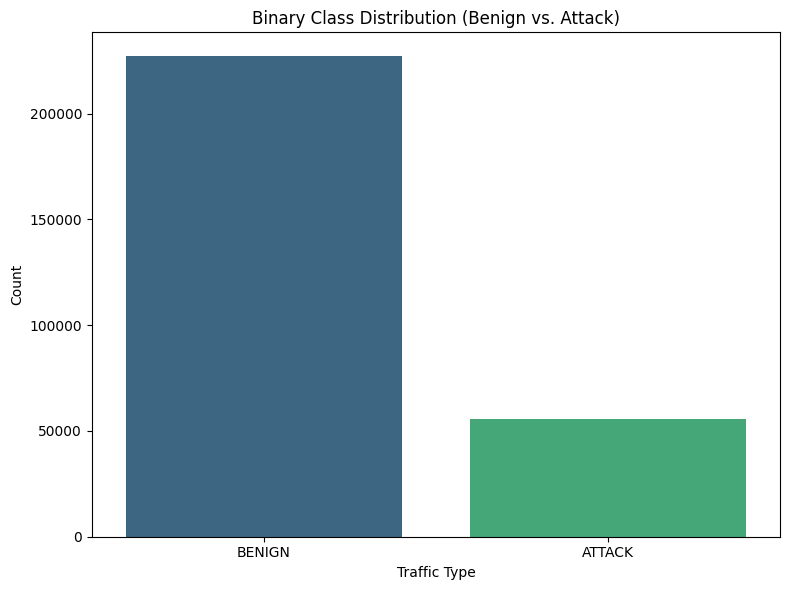

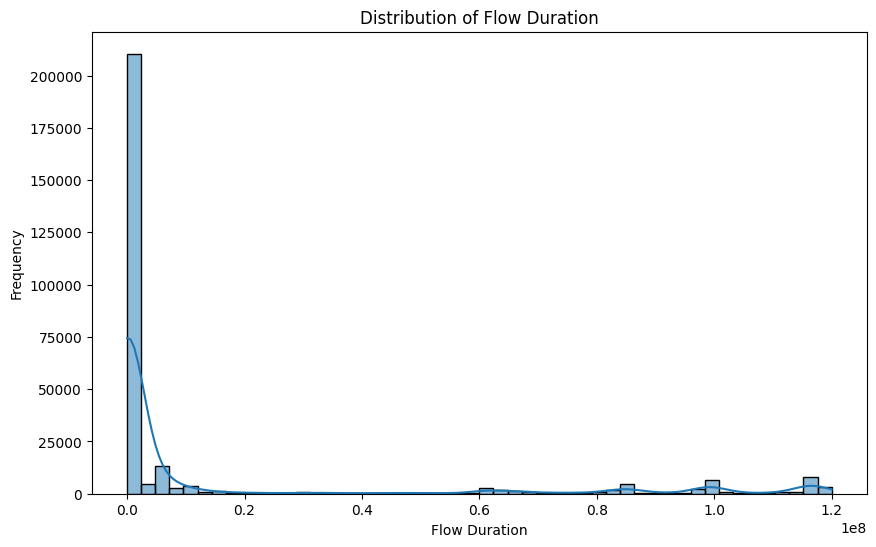

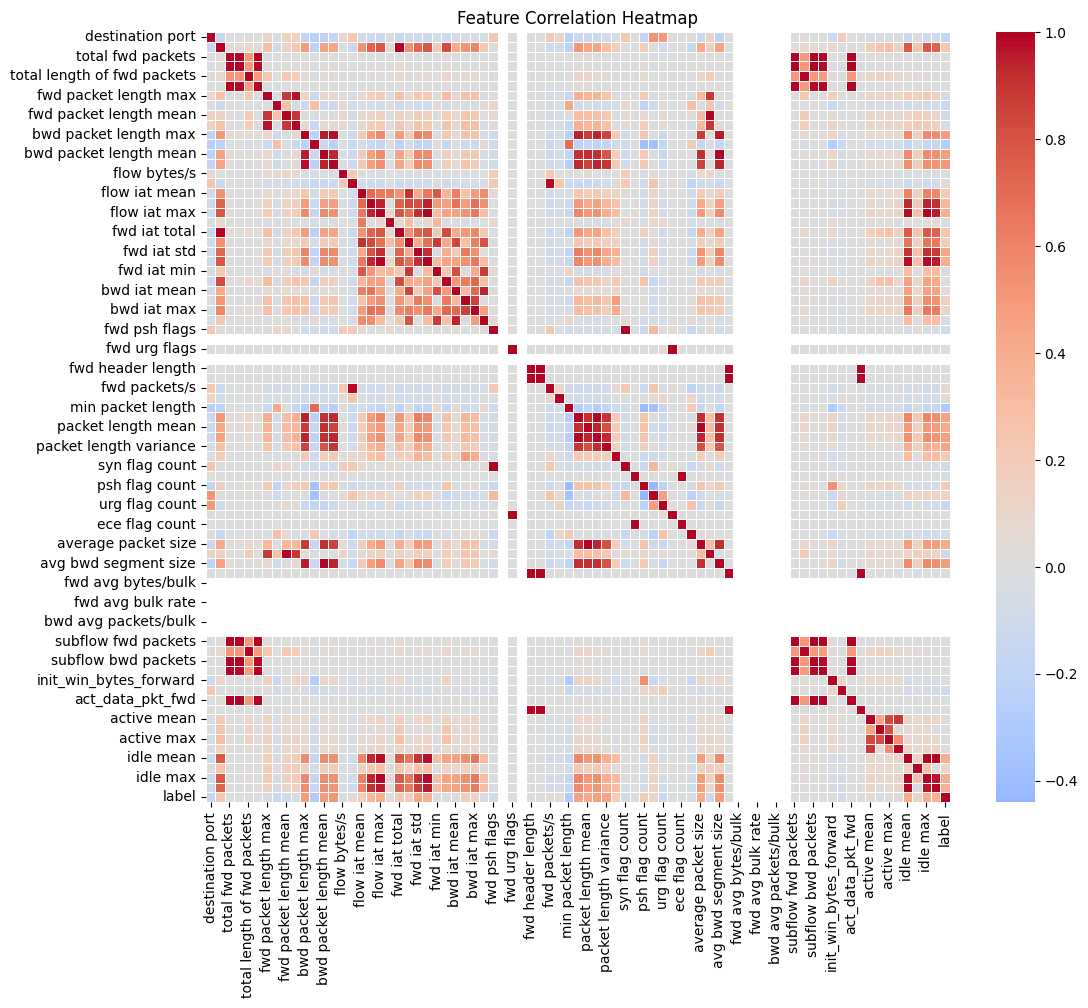


--- Histograms for Key Numerical Features ---



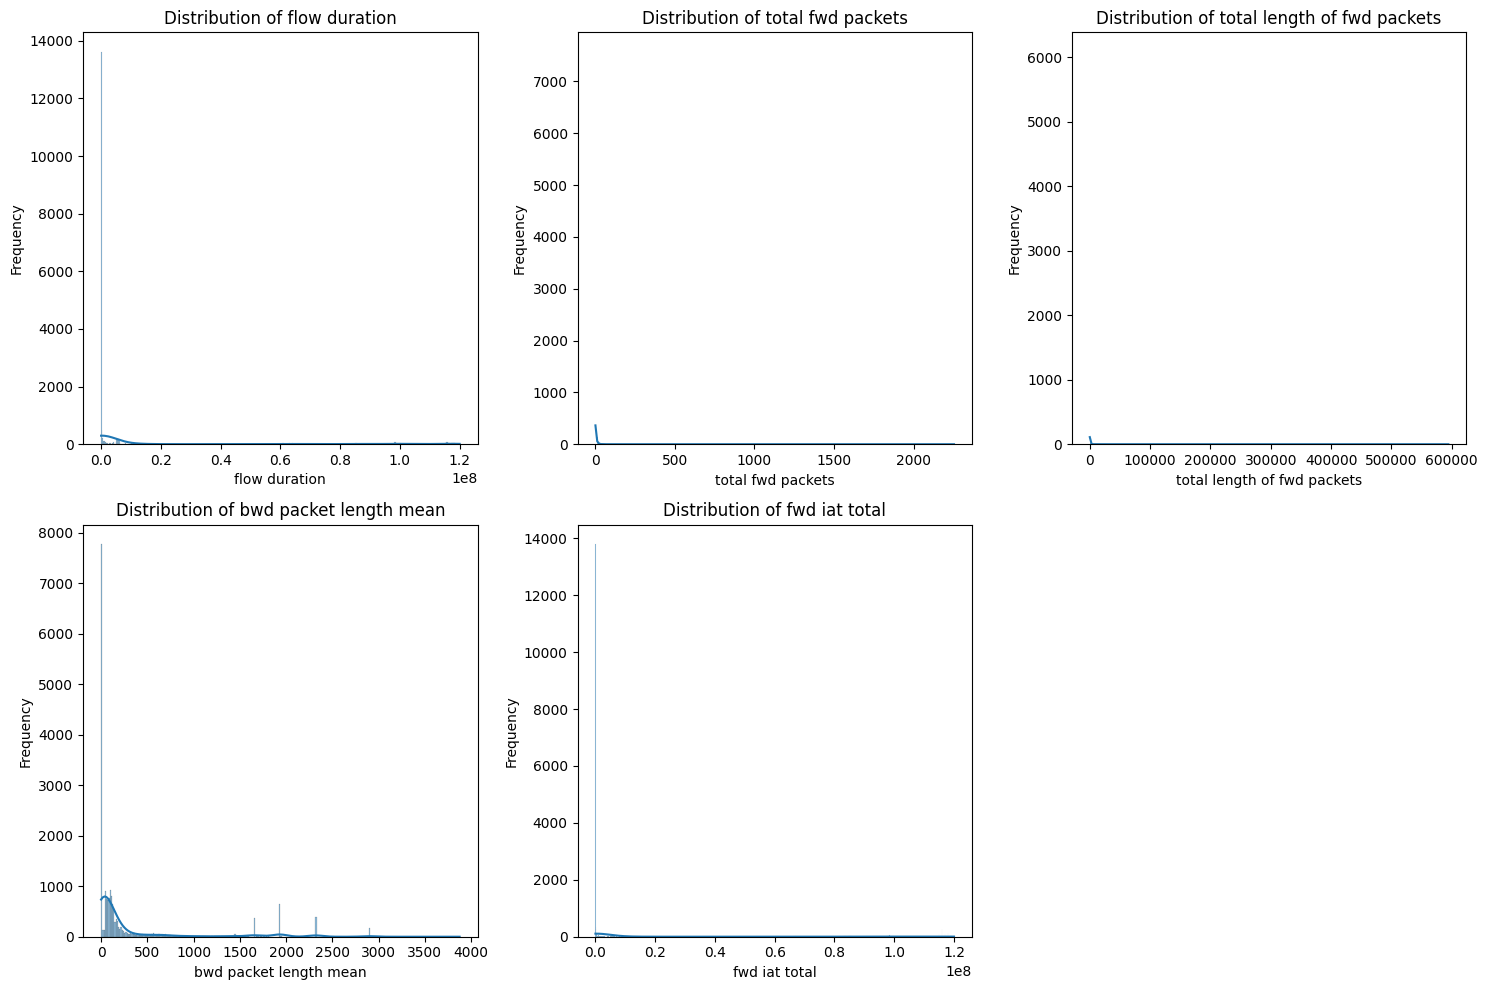


--- Box Plots for Key Numerical Features (Outlier Visualization) ---



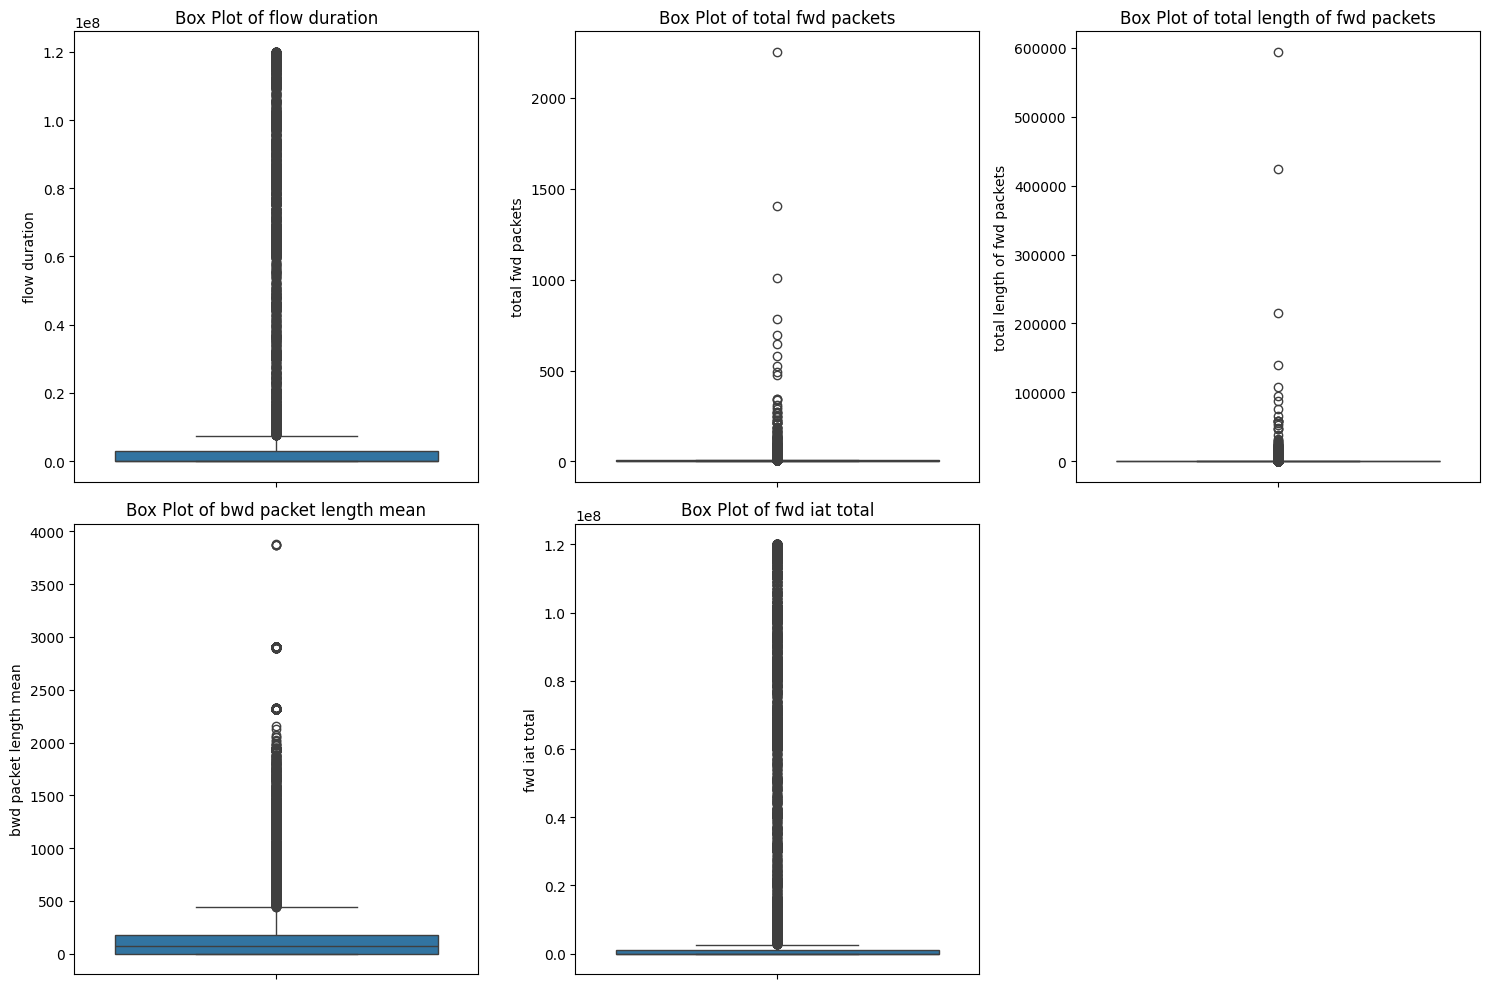


--- Pair Plot for Selected Key Features ---


<Figure size 1500x1500 with 0 Axes>

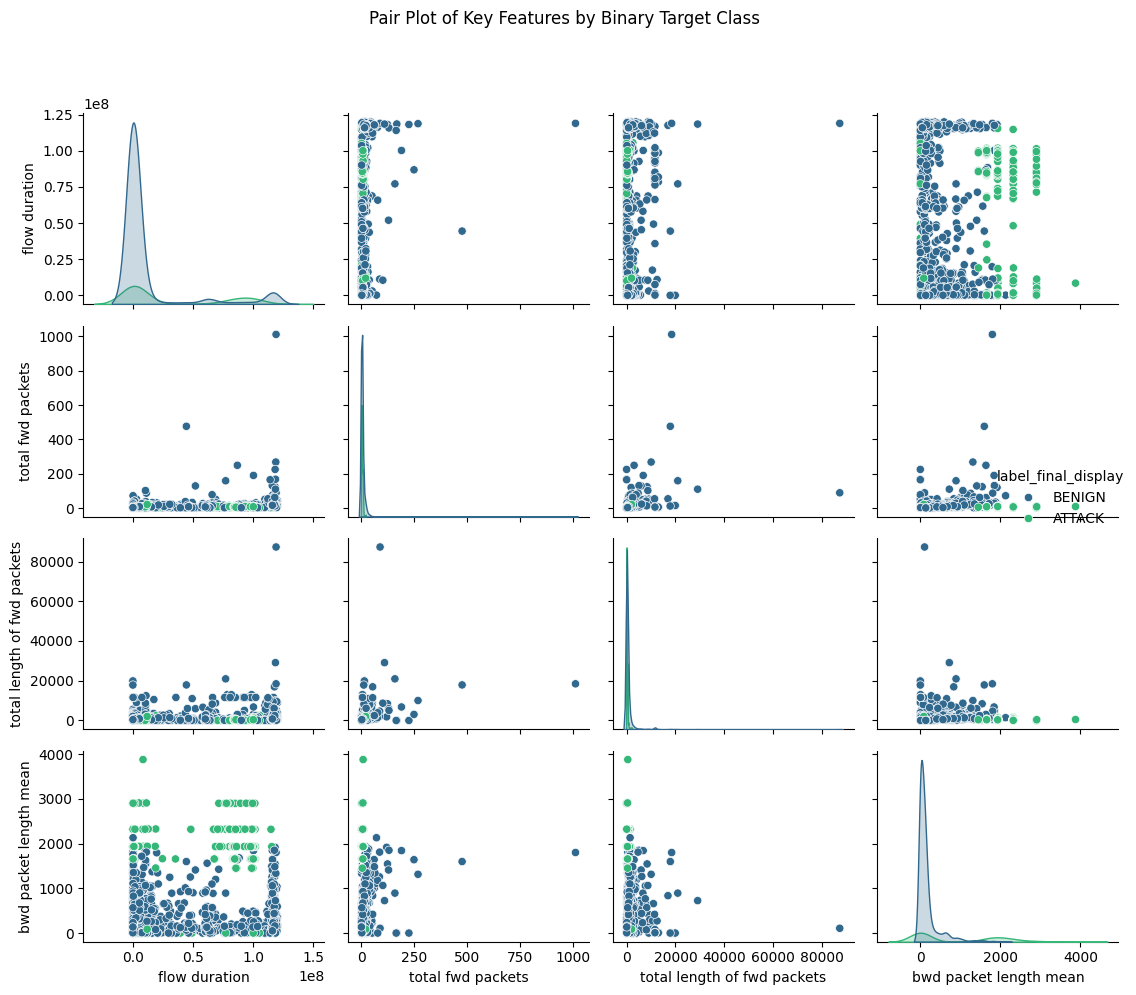


--- End Enhanced EDA ---



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Enhanced Exploratory Data Analysis (Binary Classification) ---") # Updated title
print("\nDataset Head (first 5 rows):")
print(df_subset.head())

print("\nDataset Information (Data Types and Non-Null Counts):")
df_subset.info()

print("\nDescriptive Statistics for Numerical Features:")
print(df_subset.describe())

print("\nMissing Values per Column:")
missing_values = df_subset.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")

print("\nUnique values per feature (showing features with <= 10 unique values, or indicating many):")
for column in df_subset.columns:
    unique_count = df_subset[column].nunique()
    if unique_count <= 10:
        print(f"  {column}: {unique_count} unique values -> {df_subset[column].unique()}")
    else:
        print(f"  {column}: {unique_count} unique values (many)")

print("\n--- Visual EDA ---")
# Distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='label_final_display', data=df_subset, palette='viridis')
plt.title('Binary Class Distribution (Benign vs. Attack)') # More specific title
plt.xlabel('Traffic Type') # More general label for binary
plt.ylabel('Count')
plt.xticks(rotation=0) # No need to rotate for two labels
plt.tight_layout()
plt.show()

# Example: Distribution of a numerical feature (e.g., 'flow duration')
plt.figure(figsize=(10, 6))
sns.histplot(df_subset['flow duration'], bins=50, kde=True)
plt.title('Distribution of Flow Duration')
plt.xlabel('Flow Duration')
plt.ylabel('Frequency')
plt.show()

# Heatmap of feature correlations
plt.figure(figsize=(12, 10))
corr = df_subset.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Histograms for selected numerical features
print("\n--- Histograms for Key Numerical Features ---\n")
selected_features_for_hist = [
    'flow duration',
    'total fwd packets',
    'total length of fwd packets',
    'bwd packet length mean',
    'fwd iat total'
]

# OPTIMIZATION: Sample data for plotting histograms to improve speed
plot_sample_size = min(len(df_subset), 20000) # Sample up to 20,000 data points for plotting
df_plot_sample = df_subset.sample(n=plot_sample_size, random_state=SEED)

plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features_for_hist):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_plot_sample[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print("\n--- Box Plots for Key Numerical Features (Outlier Visualization) ---\n")
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features_for_hist):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df_plot_sample[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

print("\n--- Pair Plot for Selected Key Features ---")

# Define a very small, highly relevant subset of features for pairplot
pairplot_features = [
    'flow duration',
    'total fwd packets',
    'total length of fwd packets',
    'bwd packet length mean',
    'label_final_display' # Include the target variable for class separation visualization
]

# Ensure the sample size is manageable for pairplot
pairplot_sample_size = min(len(df_subset), 5000) # Even smaller sample for pairplot if needed
df_pairplot_sample = df_subset.sample(n=pairplot_sample_size, random_state=SEED)

plt.figure(figsize=(15, 15))
sns.pairplot(df_pairplot_sample[pairplot_features], hue='label_final_display', diag_kind='kde', palette='viridis') # hue by target
plt.suptitle('Pair Plot of Key Features by Binary Target Class', y=1.02) # More specific title
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

print("\n--- End Enhanced EDA ---\n")

## 3. Train/Test Split
This section performs the crucial Train/Test Split for the dataset. It divides the features (X) and the numerically encoded target variable (y) into training and testing sets, ensuring a stratified split to maintain the original class proportions in both sets. It then verifies the success of the stratification by displaying and visualizing the proportion of each class (BENIGN vs. ATTACK) across the full dataset, training set, and test set.

--- Train/Test Split (Binary Classification) ---
X_train shape: (226230, 78)
X_test shape: (56558, 78)
y_train shape: (226230,)
y_test shape: (56558,)
Class names (from final_label_encoder): ['BENIGN' 'ATTACK']

--- Target Variable Distribution Across Splits ---


<Figure size 1200x700 with 0 Axes>

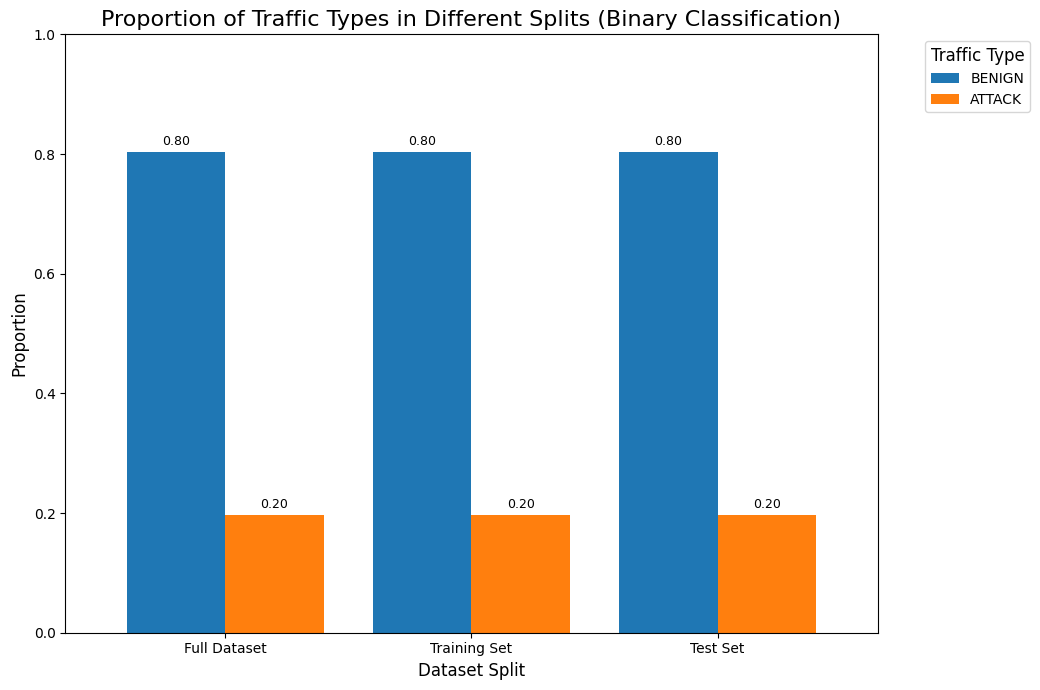


--- End Target Variable Distribution Check ---


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle # Required to load final_label_encoder if it's not in scope from previous cells
import os # Required for os.path.exists if loading from file

print("--- Train/Test Split (Binary Classification) ---") # Updated title for clarity

# Perform the train-test split using the already numerically encoded 'y'
# 'y' here should be the numerical target created by final_label_encoder in the first stage.
X_train, X_test, y_train, y_test = train_test_split(X, y, # X is features, y is already encoded target
                                                    test_size=0.2,
                                                    stratify=y, # Stratify by the already encoded 'y'
                                                    random_state=SEED) # Ensure SEED is defined from previous cells

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# --- Ensure final_label_encoder is available for inverse mapping ---
# If final_label_encoder is not directly available from the previous cell's execution, load it.
if 'final_label_encoder' not in locals():
    try:
        checkpoint_dir = './model_checkpoints' # Ensure this path is correct
        # --- FIX: Changed filename to match what was saved in the first stage for binary ---
        with open(os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder from ./model_checkpoints/final_binary_label_encoder.pkl")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found in current scope or as 'final_binary_label_encoder.pkl'. Cannot display class names or plot distribution correctly.")
        final_label_encoder = None # Set to None to prevent errors later

if final_label_encoder is not None:
    print(f"Class names (from final_label_encoder): {final_label_encoder.classes_}")
else:
    print("Warning: final_label_encoder not available. Cannot display class names.")


print("\n--- Target Variable Distribution Across Splits ---")

if final_label_encoder is not None:
    # Create a DataFrame to hold the normalized value counts for each split
    # Use final_label_encoder.classes_ to map encoded numbers back to original names for clarity
    y_distribution_df = pd.DataFrame({
        # Use 'y' (the numerically encoded full dataset target) for Full Dataset distribution
        'Full Dataset': pd.Series(y).value_counts(normalize=True).reindex(range(len(final_label_encoder.classes_))).rename(index=dict(enumerate(final_label_encoder.classes_))),
        'Training Set': pd.Series(y_train).value_counts(normalize=True).reindex(range(len(final_label_encoder.classes_))).rename(index=dict(enumerate(final_label_encoder.classes_))),
        'Test Set': pd.Series(y_test).value_counts(normalize=True).reindex(range(len(final_label_encoder.classes_))).rename(index=dict(enumerate(final_label_encoder.classes_)))
    }).T

    # If some classes have 0 occurrences in a split after reindexing, fill with 0
    y_distribution_df = y_distribution_df.fillna(0)

    plt.figure(figsize=(12, 7)) # Adjust figure size
    ax = y_distribution_df.plot(kind='bar', figsize=(12, 7), rot=0, width=0.8) # Adjust width for better visual, rot=0 for binary

    plt.title("Proportion of Traffic Types in Different Splits (Binary Classification)", fontsize=16) # Updated title
    plt.xlabel("Dataset Split", fontsize=12)
    plt.ylabel("Proportion", fontsize=12)
    plt.legend(title="Traffic Type", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12) # Updated legend title
    plt.ylim(0, 1)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)

    # Add labels to the bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9, padding=3)

    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()

else:
    print("Skipping target variable distribution plot as final_label_encoder is not available.")

print("\n--- End Target Variable Distribution Check ---")

## 4. Feature Engineering
This section performs Feature Engineering and Resampling. It preprocesses the data by capping outliers, scaling features, and reducing dimensionality with PCA, visualized via component loadings. Finally, it addresses class imbalance in the training set using SMOTE to create a balanced dataset for model training.


--- Defining and Applying Preprocessing Pipeline for Binary Classification ---
X_train_processed shape (after scaling, IQR, PCA): (226230, 6)
X_test_processed shape (after scaling, IQR, PCA): (56558, 6)
Preprocessing pipeline saved to ./model_checkpoints/preprocessor_binary.joblib
SHAP background data (sampled X_train_processed) saved to ./model_checkpoints/X_train_processed_for_shap_background_binary.joblib

Original Feature Names (before PCA):
['destination port', 'flow duration', 'total fwd packets', 'total backward packets', 'total length of fwd packets', 'total length of bwd packets', 'fwd packet length max', 'fwd packet length min', 'fwd packet length mean', 'fwd packet length std', 'bwd packet length max', 'bwd packet length min', 'bwd packet length mean', 'bwd packet length std', 'flow bytes/s', 'flow packets/s', 'flow iat mean', 'flow iat std', 'flow iat max', 'flow iat min', 'fwd iat total', 'fwd iat mean', 'fwd iat std', 'fwd iat max', 'fwd iat min', 'bwd iat total', 'bwd i

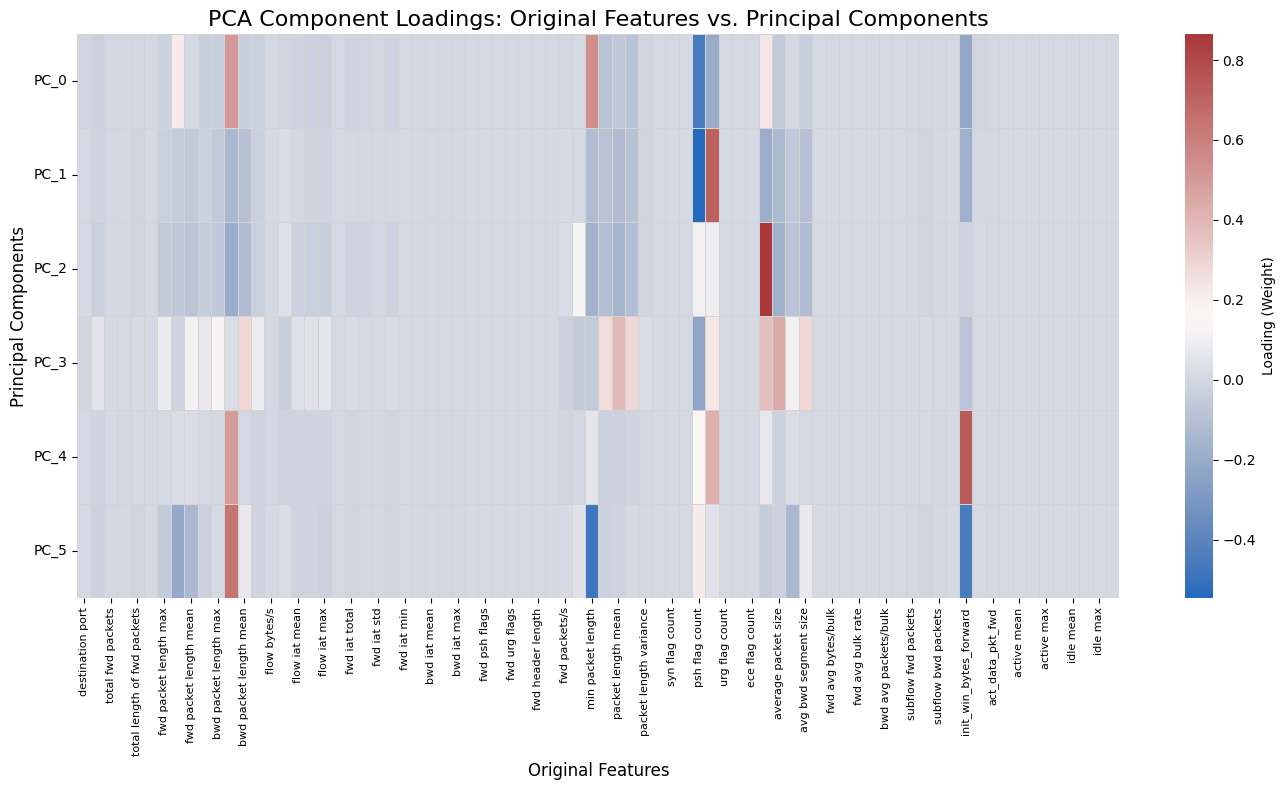


--- Interpretation of Heatmap: ---
- **Color Intensity:** A brighter color (further from white/gray) indicates a stronger loading (larger absolute value).
- **Color Hue (Red/Blue):**
  - Red (or one end of the divergent colormap): Indicates a positive loading, meaning that original feature increases with the principal component.
  - Blue (or the other end): Indicates a negative loading, meaning that original feature decreases as the principal component increases.
- By examining a row (e.g., PC_0), you can see which original features have the strongest positive or negative influence on that specific principal component.
- By examining a column (e.g., 'flow duration'), you can see how that original feature contributes across all principal components.

--- Applying SMOTE for Class Imbalance (Binary Classification) ---
Shape of X_train after SMOTE: (363410, 6)
Shape of y_train after SMOTE: (363410,)
Class distribution after SMOTE:
label
0    181705
1    181705
Name: count, dtype: int64

-

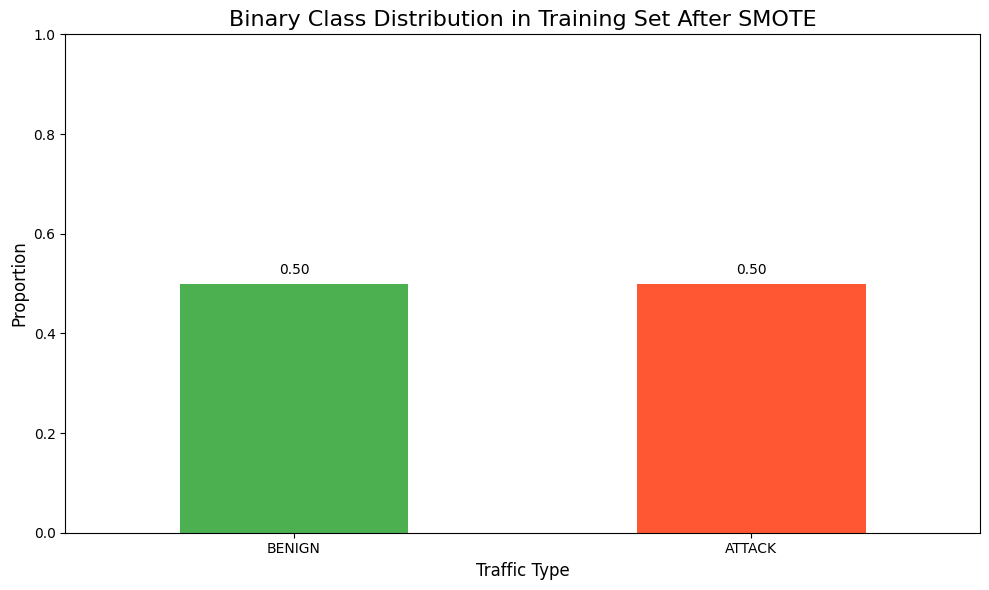


--- End Feature Engineering & Resampling ---


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
import pickle
import os
import joblib # Added joblib for saving pipelines

# Custom Transformer for IQR-based Outlier Capping
class IQROutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.lower_bound = None
        self.upper_bound = None

    def fit(self, X, y=None):
        # Calculate Q1, Q3, and IQR for each feature (column)
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_bound = Q1 - self.factor * IQR
        self.upper_bound = Q3 + self.factor * IQR
        return self

    def transform(self, X):
        # Clip values to the calculated bounds for each feature
        return np.clip(X, self.lower_bound, self.upper_bound)

print("\n--- Defining and Applying Preprocessing Pipeline for Binary Classification ---") # Updated title
# Define the preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),            # Standardize features
    ('iqr_capper', IQROutlierCapper(factor=1.5)), # Cap outliers
    ('pca', PCA(n_components=0.95))          # Apply PCA, retaining 95% of variance
])

# Fit the pipeline on training data and transform both training and test data
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

print(f"X_train_processed shape (after scaling, IQR, PCA): {X_train_processed.shape}")
print(f"X_test_processed shape (after scaling, IQR, PCA): {X_test_processed.shape}")

# --- Save the fitted preprocessing pipeline ---
preprocessor_path = os.path.join(checkpoint_dir, 'preprocessor_binary.joblib')
joblib.dump(preprocessing_pipeline, preprocessor_path)
print(f"Preprocessing pipeline saved to {preprocessor_path}")

# --- Save a small sample of X_train_processed for SHAP background data ---
# This is crucial for KernelExplainer and DeepExplainer in the prediction stage
shap_background_sample_size = min(500, X_train_processed.shape[0]) # Limit size for efficiency
np.random.seed(SEED) # Ensure reproducibility
if X_train_processed.shape[0] > 0:
    indices = np.random.choice(X_train_processed.shape[0], shap_background_sample_size, replace=False)
    X_train_processed_for_shap_background = X_train_processed[indices]
    shap_background_path = os.path.join(checkpoint_dir, 'X_train_processed_for_shap_background_binary.joblib')
    joblib.dump(X_train_processed_for_shap_background, shap_background_path)
    print(f"SHAP background data (sampled X_train_processed) saved to {shap_background_path}")
else:
    print("Warning: X_train_processed is empty. Cannot save SHAP background data.")


# Get original feature names from X_train (assuming X_train is a Pandas DataFrame)
if isinstance(X_train, pd.DataFrame):
    original_feature_names = X_train.columns.tolist()
else:
    # Fallback for NumPy arrays if X_train is not a DataFrame
    num_original_features = X_train.shape[1]
    original_feature_names = [f'Original_Feature_{i}' for i in range(num_original_features)]

print(f"\nOriginal Feature Names (before PCA):")
print(original_feature_names)

# Print the features (Principal Components) remaining after PCA
num_pca_components = X_train_processed.shape[1]
pca_features = [f'PC_{i}' for i in range(num_pca_components)]
print(f"\nFeatures remaining after PCA (Principal Components):")
print(pca_features)


print("\n--- Mapping of Principal Components to Original Features (PCA Loadings) ---")
# Access the fitted PCA model from the pipeline
pca_model = preprocessing_pipeline.named_steps['pca']

# The components_ attribute holds the principal components (eigenvectors)
# Each row is a principal component, and columns are original features
pca_loadings = pd.DataFrame(pca_model.components_,
                             columns=original_feature_names,
                             index=pca_features)

print("This table shows the 'loadings' or 'weights' of each original feature on each Principal Component:")
print(pca_loadings)

print("\nInterpretation Notes:")
print("- Each row represents a Principal Component (e.g., PC_0).")
print("- Each column represents an Original Feature.")
print("- The values in the table indicate how much each original feature contributes to each Principal Component.")
print("- Larger absolute values (positive or negative) mean a stronger contribution.")
print("- For example, looking at PC_0, features with the largest absolute values are the most influential in defining PC_0.")


# --- VISUALIZATION START ---
plt.figure(figsize=(14, max(8, num_pca_components * 0.8))) # Adjust figure size dynamically
sns.heatmap(pca_loadings, cmap='vlag', annot=False, fmt=".2f", linewidths=.5, linecolor='lightgray',
            cbar_kws={'label': 'Loading (Weight)'})
plt.title('PCA Component Loadings: Original Features vs. Principal Components', fontsize=16)
plt.xlabel('Original Features', fontsize=12)
plt.ylabel('Principal Components', fontsize=12)
plt.xticks(rotation=90, fontsize=8) # Rotate labels for readability
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("\n--- Interpretation of Heatmap: ---")
print("- **Color Intensity:** A brighter color (further from white/gray) indicates a stronger loading (larger absolute value).")
print("- **Color Hue (Red/Blue):**")
print("  - Red (or one end of the divergent colormap): Indicates a positive loading, meaning that original feature increases with the principal component.")
print("  - Blue (or the other end): Indicates a negative loading, meaning that original feature decreases as the principal component increases.")
print("- By examining a row (e.g., PC_0), you can see which original features have the strongest positive or negative influence on that specific principal component.")
print("- By examining a column (e.g., 'flow duration'), you can see how that original feature contributes across all principal components.")
# --- VISUALIZATION END ---

print("\n--- Applying SMOTE for Class Imbalance (Binary Classification) ---") # Updated title
# Apply SMOTE to the processed training data only
smote = SMOTE(random_state=SEED, sampling_strategy='auto', k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

print(f"Shape of X_train after SMOTE: {X_train_res.shape}")
print(f"Shape of y_train after SMOTE: {y_train_res.shape}")
print("Class distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

print("\n--- Target Variable Distribution After SMOTE ---")

# Ensure final_label_encoder is available for inverse mapping for the plot
if 'final_label_encoder' not in locals():
    try:
        # Load the binary-specific encoder
        with open(os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder for SMOTE plot.")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found for SMOTE plot. Cannot map numerical labels to names.")
        final_label_encoder = None # Set to None to prevent errors later

if final_label_encoder is not None:
    # Create a Series from y_train_res and get normalized value counts
    smote_distribution = pd.Series(y_train_res).value_counts(normalize=True)

    # Reindex to ensure all classes are present and use original class names from final_label_encoder
    smote_distribution = smote_distribution.reindex(range(len(final_label_encoder.classes_))).fillna(0)
    smote_distribution.index = final_label_encoder.classes_ # Map numerical labels back to original names

    plt.figure(figsize=(10, 6))
    # Use specific colors for binary labels and remove xtick rotation for better readability
    ax = smote_distribution.plot(kind='bar', color=['#4CAF50', '#FF5733'], rot=0) # Example: Green for BENIGN, Orange for ATTACK

    plt.title("Binary Class Distribution in Training Set After SMOTE", fontsize=16) # Updated title
    plt.xlabel("Traffic Type", fontsize=12) # Updated label for binary context
    plt.ylabel("Proportion", fontsize=12)
    plt.ylim(0, 1) # Proportions range from 0 to 1
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Add value labels on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10, padding=5)

    plt.tight_layout()
    plt.show()
else:
    print("Skipping SMOTE distribution plot as final_label_encoder is not available.")

print("\n--- End Feature Engineering & Resampling ---")

## 5. Classification Task ML Modeling
This section focuses on training and initial evaluation of various machine learning and deep learning models for binary classification. It establishes a baseline with a Dummy Classifier, then trains untuned Logistic Regression, Random Forest, and XGBoost models, performing cross-validation for robust assessment. Finally, it defines, trains, and evaluates Feedforward Neural Network (FFN) and Long Short-Term Memory (LSTM) models using PyTorch. All models are evaluated on the processed test set using metrics like F1-score and ROC AUC, and then saved.

In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import joblib
import os
import pickle

# Ensure final_label_encoder is available if not in scope (e.g., if running cell by itself)
if 'final_label_encoder' not in locals():
    try:
        # Corrected filename for loading the binary encoder
        with open(os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder for current stage.")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found in current scope or as 'final_binary_label_encoder.pkl'. Please ensure previous stages were run.")
        final_label_encoder = None
    except Exception as e:
        print(f"An unexpected error occurred while loading final_label_encoder: {e}")
        final_label_encoder = None

# Define num_classes based on the loaded encoder (should be 2 for binary)
num_classes = len(final_label_encoder.classes_) if final_label_encoder is not None else 2

# Verify num_classes for binary scenario
if num_classes != 2:
    print(f"Warning: Number of classes detected is {num_classes}. This code is optimized for binary classification (2 classes).")

# Prepare target names for classification reports
unique_test_labels = np.unique(y_test)
if final_label_encoder is not None:
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    filtered_target_names = [f'Class {label}' for label in sorted(unique_test_labels)]


# --- Baseline Model (Dummy Classifier) ---
print("\n--- Training Baseline Model (Dummy Classifier) ---")
dummy_model = DummyClassifier(strategy='most_frequent', random_state=SEED)
dummy_model.fit(X_train_res, y_train_res)

# Checkpoint 1: Save Dummy Classifier
dummy_model_path = os.path.join(checkpoint_dir, "dummy_binary_model.pkl") # Added 'binary'
joblib.dump(dummy_model, dummy_model_path)
print(f"Checkpoint: Dummy Classifier saved to {dummy_model_path}")

y_pred_dummy = dummy_model.predict(X_test_processed)

print("\nClassification Report for Baseline Model:")
print(classification_report(y_test, y_pred_dummy, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))


# Define simplified "pipelines" (just the model) since preprocessing is already done on X_train_res and X_test_processed
print("\n--- Defining Model 'Pipelines' (Model Only) for Binary Classification ---")

# --- Logistic Regression ---
pipeline_lr = Pipeline([
    ('model', LogisticRegression(solver='lbfgs', multi_class='auto', random_state=SEED, n_jobs=-1))
])

# --- Random Forest Classifier ---
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1, class_weight='balanced'))
])

# --- XGBoost Classifier ---
pipeline_xgb = Pipeline([
    ('model', xgb.XGBClassifier(objective='binary:logistic',
                                eval_metric='logloss',
                                n_estimators=100, random_state=SEED, n_jobs=-1, tree_method='hist'))
])

# --- Logistic Regression Training and CV ---
print("\n--- Training Logistic Regression Model Pipeline ---")
pipeline_lr.fit(X_train_res, y_train_res)

# Checkpoint 2: Save Logistic Regression Pipeline
lr_pipeline_path = os.path.join(checkpoint_dir, "logistic_regression_binary_pipeline.pkl") # Added 'binary'
joblib.dump(pipeline_lr, lr_pipeline_path)
print(f"Checkpoint: Logistic Regression Pipeline saved to {lr_pipeline_path}")

y_pred_lr = pipeline_lr.predict(X_test_processed)
y_prob_lr = pipeline_lr.predict_proba(X_test_processed)[:, 1]

print("\n--- Cross-Validation for Logistic Regression Pipeline ---")
cv_scores_lr = cross_val_score(pipeline_lr, X_train_res, y_train_res,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                               scoring='f1',
                               n_jobs=-1,
                               verbose=0)
print(f"Logistic Regression CV F1-scores: {cv_scores_lr}")
print(f"Logistic Regression Mean CV F1-score: {np.mean(cv_scores_lr):.4f} (+/- {np.std(cv_scores_lr):.4f})")

roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
print(f"Logistic Regression ROC AUC: {roc_auc_lr:.4f}")

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))


# --- Random Forest Classifier Training and CV ---
print("\n--- Training Random Forest Model Pipeline ---")
pipeline_rf.fit(X_train_res, y_train_res)

# Checkpoint 3: Save Random Forest Pipeline
rf_pipeline_path = os.path.join(checkpoint_dir, "random_forest_binary_pipeline.pkl") # Added 'binary'
joblib.dump(pipeline_rf, rf_pipeline_path)
print(f"Checkpoint: Random Forest Pipeline saved to {rf_pipeline_path}")

y_pred_rf = pipeline_rf.predict(X_test_processed)
y_prob_rf = pipeline_rf.predict_proba(X_test_processed)[:, 1]

print("\n--- Cross-Validation for Random Forest Pipeline ---")
cv_scores_rf = cross_val_score(pipeline_rf, X_train_res, y_train_res,
                               cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                               scoring='f1',
                               n_jobs=-1,
                               verbose=0)
print(f"Random Forest CV F1-scores: {cv_scores_rf}")
print(f"Random Forest Mean CV F1-score: {np.mean(cv_scores_rf):.4f} (+/- {np.std(cv_scores_rf):.4f})")

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"Random Forest ROC AUC: {roc_auc_rf:.4f}")

print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))


# --- XGBoost Classifier Training and CV ---
print("\n--- Training Initial XGBoost Model Pipeline ---")
pipeline_xgb.fit(X_train_res, y_train_res)

# Checkpoint 4: Save XGBoost Pipeline
xgb_pipeline_path = os.path.join(checkpoint_dir, "xgboost_binary_pipeline.pkl") # Added 'binary'
joblib.dump(pipeline_xgb, xgb_pipeline_path)
print(f"Checkpoint: XGBoost Pipeline saved to {xgb_pipeline_path}")

y_pred_xgb = pipeline_xgb.predict(X_test_processed)
y_prob_xgb = pipeline_xgb.predict_proba(X_test_processed)[:, 1]

print("\n--- Cross-Validation for Initial XGBoost Model Pipeline ---")
cv_scores_xgb = cross_val_score(pipeline_xgb, X_train_res, y_train_res,
                                 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                                 scoring='f1',
                                 n_jobs=-1,
                                 verbose=0)
print(f"Initial XGBoost CV F1-scores: {cv_scores_xgb}")
print(f"Initial XGBoost Mean CV F1-score: {np.mean(cv_scores_xgb):.4f} (+/- {np.std(cv_scores_xgb):.4f})")

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"XGBoost ROC AUC: {roc_auc_xgb:.4f}")

print("\nClassification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))


# --- PyTorch Neural Networks (FFN and LSTM) ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device for PyTorch models: {device}")

X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


# Define simple feedforward network for BINARY CLASSIFICATION
class FFN(nn.Module):
    def __init__(self, input_dim):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1) # Output layer for binary classification (logits)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) # Output logits
        return x

# Define RNN (LSTM) Model for BINARY CLASSIFICATION
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1) # Output layer for binary classification (logits)

    def forward(self, x):
        x = x.unsqueeze(-1)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Instantiate and train FFN
print("\n--- Training Feedforward Neural Network (Binary Classification) ---")
ffn_model = FFN(X_train_res.shape[1]).to(device)
criterion_ffn = nn.BCEWithLogitsLoss()
optimizer_ffn = optim.Adam(ffn_model.parameters(), lr=0.001)

epochs_ffn = 30
ffn_model.train()
ffn_train_losses = []
for epoch in range(epochs_ffn):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
        optimizer_ffn.zero_grad()
        outputs = ffn_model(batch_X)
        loss = criterion_ffn(outputs, batch_y)
        loss.backward()
        optimizer_ffn.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss/len(train_loader)
    ffn_train_losses.append(avg_epoch_loss)
    print(f"FFN Epoch {epoch+1}/{epochs_ffn}, Loss: {avg_epoch_loss:.4f}")

# Checkpoint 5: Save FFN Model
ffn_model_path = os.path.join(checkpoint_dir, "ffn_binary_model_state_dict.pth") # Added 'binary'
torch.save(ffn_model.state_dict(), ffn_model_path)
print(f"Checkpoint: FFN model state_dict saved to {ffn_model_path}")

ffn_model.eval()
with torch.no_grad():
    X_test_tensor_ffn = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
    y_pred_logits_ffn = ffn_model(X_test_tensor_ffn).cpu().squeeze(1)
    y_pred_proba_ffn = torch.sigmoid(y_pred_logits_ffn).numpy()
    y_pred_labels_ffn = (y_pred_proba_ffn >= 0.5).astype(int)

print("\nClassification Report for FFN:")
print(classification_report(y_test, y_pred_labels_ffn, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))

roc_auc_ffn = roc_auc_score(y_test, y_pred_proba_ffn)
print(f"FFN ROC AUC: {roc_auc_ffn:.4f}")


# Instantiate and train LSTMNet
print("\n--- Training Recurrent Neural Network (LSTM) (Binary Classification) ---")
input_dim_lstm = X_train_res.shape[1]
hidden_dim_lstm = 64
num_layers_lstm = 1

lstm_model = LSTMNet(input_dim_lstm, hidden_dim_lstm, num_layers_lstm).to(device)
criterion_lstm = nn.BCEWithLogitsLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

epochs_lstm = 50
lstm_model.train()
lstm_train_losses = []
for epoch in range(epochs_lstm):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
        optimizer_lstm.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion_lstm(outputs, batch_y)
        loss.backward()
        optimizer_lstm.step()
        epoch_loss += loss.item()
    avg_epoch_loss = epoch_loss/len(train_loader)
    lstm_train_losses.append(avg_epoch_loss)
    print(f"LSTM Epoch {epoch+1}/{epochs_lstm}, Loss: {avg_epoch_loss:.4f}")

# Checkpoint 6: Save LSTM Model
lstm_model_path = os.path.join(checkpoint_dir, "lstm_binary_model_state_dict.pth") # Added 'binary'
torch.save(lstm_model.state_dict(), lstm_model_path)
print(f"Checkpoint: LSTM model state_dict saved to {lstm_model_path}")

lstm_model.eval()
with torch.no_grad():
    X_test_tensor_lstm = torch.tensor(X_test_processed, dtype=torch.float32).to(device)
    y_pred_logits_lstm = lstm_model(X_test_tensor_lstm).cpu().squeeze(1)
    y_pred_proba_lstm = torch.sigmoid(y_pred_logits_lstm).numpy()
    y_pred_labels_lstm = (y_pred_proba_lstm >= 0.5).astype(int)

print("\nClassification Report for LSTM:")
print(classification_report(y_test, y_pred_labels_lstm, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))

roc_auc_lstm = roc_auc_score(y_test, y_pred_proba_lstm)
print(f"LSTM ROC AUC: {roc_auc_lstm:.4f}")

print("\n--- End Model Training and Evaluation ---")


--- Training Baseline Model (Dummy Classifier) ---
Checkpoint: Dummy Classifier saved to ./model_checkpoints/dummy_binary_model.pkl

Classification Report for Baseline Model:
              precision    recall  f1-score   support

      BENIGN       0.80      1.00      0.89     45427
      ATTACK       0.00      0.00      0.00     11131

    accuracy                           0.80     56558
   macro avg       0.40      0.50      0.45     56558
weighted avg       0.65      0.80      0.72     56558


--- Defining Model 'Pipelines' (Model Only) for Binary Classification ---

--- Training Logistic Regression Model Pipeline ---
Checkpoint: Logistic Regression Pipeline saved to ./model_checkpoints/logistic_regression_binary_pipeline.pkl

--- Cross-Validation for Logistic Regression Pipeline ---
Logistic Regression CV F1-scores: [0.73794101 0.73820055 0.73404165 0.73834585 0.73922445]
Logistic Regression Mean CV F1-score: 0.7376 (+/- 0.0018)
Logistic Regression ROC AUC: 0.7970

Classification

## 6(a). Hyperparameter Tuning for Logistic Regression, Random Forest, and XGBoost Models
This section focuses on Hyperparameter Tuning for the previously defined Logistic Regression, Random Forest, and XGBoost models. Using GridSearchCV with stratified cross-validation and F1-score as the primary metric, it systematically searches for the optimal hyperparameters for each model. The best-performing tuned models are then saved and their performance is reported on the test set using detailed classification reports.

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, roc_auc_score # Added roc_auc_score for potential use
import xgboost as xgb
import os
import joblib
import pickle # Ensure pickle is imported for loading LabelEncoder

# Ensure final_label_encoder is available if not in scope (e.g., if running cell by itself)
if 'final_label_encoder' not in locals():
    try:
        # --- FIX: Corrected filename for loading the binary encoder ---
        with open(os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder for current stage.")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found in current scope or as 'final_binary_label_encoder.pkl'. Please ensure previous stages were run.")
        final_label_encoder = None
    except Exception as e:
        print(f"An unexpected error occurred while loading final_label_encoder: {e}")
        final_label_encoder = None

# Pre-calculate unique labels and filtered target names for classification_report
if final_label_encoder is not None:
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    print("Warning: final_label_encoder not available. Classification reports may use default labels.")
    unique_test_labels = np.unique(y_test)
    filtered_target_names = None


print("\n--- Hyperparameter Tuning for Logistic Regression Pipeline (GridSearchCV) ---")

param_grid_lr = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['lbfgs', 'saga'], # 'saga' supports 'l1' and 'elasticnet' penalties
    'model__penalty': ['l2'] # 'lbfgs' only supports 'l2'
}

grid_search_lr_pipeline = GridSearchCV(estimator=pipeline_lr,
                                       param_grid=param_grid_lr,
                                       scoring='f1', # Changed scoring to 'f1' for binary classification (positive class)
                                       # Alternatively, 'roc_auc' is also a very common and robust metric for binary tuning.
                                       cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                                       verbose=0,
                                       n_jobs=-1)

# Fit GridSearchCV on your processed and resampled training data
grid_search_lr_pipeline.fit(X_train_res, y_train_res)

print(f"\nBest parameters for Logistic Regression Pipeline: {grid_search_lr_pipeline.best_params_}")
print(f"Best cross-validation F1-score for Logistic Regression: {grid_search_lr_pipeline.best_score_:.4f}")

# Store the best performing Logistic Regression model (which is part of a pipeline)
best_lr_model_pipeline = grid_search_lr_pipeline.best_estimator_

# Checkpoint 1: Save Tuned Logistic Regression Pipeline
tuned_lr_pipeline_path = os.path.join(checkpoint_dir, "tuned_logistic_regression_binary_pipeline.pkl") # Added 'binary'
joblib.dump(best_lr_model_pipeline, tuned_lr_pipeline_path)
print(f"Checkpoint: Tuned Logistic Regression Pipeline saved to {tuned_lr_pipeline_path}")


# Make predictions on the preprocessed test set
y_pred_best_lr = best_lr_model_pipeline.predict(X_test_processed)

print("\nClassification Report for Best Tuned Logistic Regression Model:")
if filtered_target_names:
    print(classification_report(y_test, y_pred_best_lr, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print(classification_report(y_test, y_pred_best_lr, zero_division=0))


print("\n--- Hyperparameter Tuning for Random Forest Pipeline (GridSearchCV) ---")

param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt', 'log2']
}

grid_search_rf_pipeline = GridSearchCV(estimator=pipeline_rf,
                                       param_grid=param_grid_rf,
                                       scoring='f1', # Changed scoring to 'f1' for binary classification (positive class)
                                       cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
                                       verbose=0,
                                       n_jobs=-1)

# Fit GridSearchCV on X_train_res, y_train_res
grid_search_rf_pipeline.fit(X_train_res, y_train_res)

print(f"\nBest parameters for Random Forest Pipeline: {grid_search_rf_pipeline.best_params_}")
print(f"Best cross-validation F1-score for Random Forest: {grid_search_rf_pipeline.best_score_:.4f}")

best_rf_model_pipeline = grid_search_rf_pipeline.best_estimator_

# Checkpoint 2: Save Tuned Random Forest Pipeline
tuned_rf_pipeline_path = os.path.join(checkpoint_dir, "tuned_random_forest_binary_pipeline.pkl") # Added 'binary'
joblib.dump(best_rf_model_pipeline, tuned_rf_pipeline_path)
print(f"Checkpoint: Tuned Random Forest Pipeline saved to {tuned_rf_pipeline_path}")

y_pred_best_rf = best_rf_model_pipeline.predict(X_test_processed)

print("\nClassification Report for Best Tuned Random Forest Model:")
if filtered_target_names:
    print(classification_report(y_test, y_pred_best_rf, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print(classification_report(y_test, y_pred_best_rf, zero_division=0))


# Hyperparameter tuning for XGBoost Pipeline
print("\n--- Hyperparameter Tuning for XGBoost Pipeline (GridSearchCV) ---")

param_grid_pipeline_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.7, 1.0]
}

grid_search_xgb_pipeline = GridSearchCV(estimator=pipeline_xgb,
                                        param_grid=param_grid_pipeline_xgb,
                                        scoring='f1', # Changed scoring to 'f1' for binary classification (positive class)
                                        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
                                        verbose=0, n_jobs=-1)

# Fit GridSearchCV on X_train_res, y_train_res (already processed and resampled)
grid_search_xgb_pipeline.fit(X_train_res, y_train_res)

print(f"\nBest parameters for XGBoost Pipeline: {grid_search_xgb_pipeline.best_params_}")
best_xgb_model_pipeline = grid_search_xgb_pipeline.best_estimator_

# Checkpoint 3: Save Tuned XGBoost Pipeline
tuned_xgb_pipeline_path = os.path.join(checkpoint_dir, "tuned_xgboost_binary_pipeline.pkl") # Added 'binary'
joblib.dump(best_xgb_model_pipeline, tuned_xgb_pipeline_path)
print(f"Checkpoint: Tuned XGBoost Pipeline saved to {tuned_xgb_pipeline_path}")

y_pred_best_xgb = best_xgb_model_pipeline.predict(X_test_processed)

print("\nClassification Report for Best Tuned XGBoost Model:")
if filtered_target_names:
    print(classification_report(y_test, y_pred_best_xgb, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print(classification_report(y_test, y_pred_best_xgb, zero_division=0))


--- Hyperparameter Tuning for Logistic Regression Pipeline (GridSearchCV) ---

Best parameters for Logistic Regression Pipeline: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'saga'}
Best cross-validation F1-score for Logistic Regression: 0.7376
Checkpoint: Tuned Logistic Regression Pipeline saved to ./model_checkpoints/tuned_logistic_regression_binary_pipeline.pkl

Classification Report for Best Tuned Logistic Regression Model:
              precision    recall  f1-score   support

      BENIGN       0.93      0.57      0.71     45427
      ATTACK       0.32      0.83      0.47     11131

    accuracy                           0.62     56558
   macro avg       0.63      0.70      0.59     56558
weighted avg       0.81      0.62      0.66     56558


--- Hyperparameter Tuning for Random Forest Pipeline (GridSearchCV) ---

Best parameters for Random Forest Pipeline: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_s

## 6(b). Training the Stacking Classifier
This section trains and evaluates a Stacking Classifier for binary classification. It leverages the previously hyperparameter-tuned Logistic Regression, Random Forest, and XGBoost models as base estimators. A Logistic Regression model acts as the meta-classifier, learning to combine the predictions of the base models. The stacking ensemble is trained using stratified cross-validation on the processed and resampled training data, then saved. Finally, its performance is evaluated on the processed test set using a classification report and ROC AUC score.

In [19]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score # Added roc_auc_score for potential use
import numpy as np
import os
import joblib
import pandas as pd
import pickle

print("\n--- Training Stacking Classifier ---")
# Ensure final_label_encoder is available if not in scope (e.g., if running cell by itself)
if 'final_label_encoder' not in locals():
    try:
        # Load the binary-specific label encoder
        with open(os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_label_encoder for current stage.")
    except FileNotFoundError:
        print("Error: 'final_label_encoder' not found in current scope or as 'final_binary_label_encoder.pkl'. Please ensure previous stages were run.")
        final_label_encoder = None
    except Exception as e:
        print(f"An unexpected error occurred while loading final_label_encoder: {e}")
        final_label_encoder = None

# Pre-calculate unique labels and filtered target names for classification_report
if final_label_encoder is not None:
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    print("Warning: final_label_encoder not available. Classification reports may use default labels.")
    unique_test_labels = np.unique(y_test)
    filtered_target_names = None


# Define the base estimators.
# These pipelines should already be configured for binary classification
# and loaded from their respective 'tuned_..._binary_pipeline.pkl' files.
estimators = [
    ('lr', best_lr_model_pipeline),
    ('rf', best_rf_model_pipeline),
    ('xgb', best_xgb_model_pipeline)
]

# Define the meta-classifier (final estimator).
# For binary classification, multi_class='auto' is appropriate.
# It will use 'binary' if there are only two classes.
meta_classifier = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=SEED, n_jobs=-1)

# Create the StackingClassifier
stacked_classifier = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED),
    n_jobs=-1,
    verbose=0
)

# Fit the StackingClassifier on the processed and resampled training data
print("Fitting Stacking Classifier...")
stacked_classifier.fit(X_train_res, y_train_res)
print("Stacking Classifier training complete.")

# Checkpoint 1: Save the trained Stacking Classifier
stacked_classifier_path = os.path.join(checkpoint_dir, "stacked_binary_classifier.pkl") # Added 'binary'
joblib.dump(stacked_classifier, stacked_classifier_path)
print(f"Checkpoint: Stacking Classifier saved to {stacked_classifier_path}")

# Predict on the processed test data
y_pred_stacked = stacked_classifier.predict(X_test_processed)
y_prob_stacked = stacked_classifier.predict_proba(X_test_processed)[:, 1] # Probability of the positive class

print("\nClassification Report for Stacking Classifier:")
if filtered_target_names:
    print(classification_report(y_test, y_pred_stacked, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))
else:
    print(classification_report(y_test, y_pred_stacked, zero_division=0))

roc_auc_stacked = roc_auc_score(y_test, y_prob_stacked)
print(f"Stacking Classifier ROC AUC: {roc_auc_stacked:.4f}")


--- Training Stacking Classifier ---
Fitting Stacking Classifier...
Stacking Classifier training complete.
Checkpoint: Stacking Classifier saved to ./model_checkpoints/stacked_binary_classifier.pkl

Classification Report for Stacking Classifier:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     45427
      ATTACK       0.98      0.99      0.99     11131

    accuracy                           0.99     56558
   macro avg       0.99      0.99      0.99     56558
weighted avg       0.99      0.99      0.99     56558

Stacking Classifier ROC AUC: 0.9995


## 6(c). Hyperparameter Tuning of the FFN
This section orchestrates hyperparameter tuning for the PyTorch Feedforward Neural Network (FFN) using Optuna. It defines the FFN architecture, then trains and validates multiple FFN instances with various hyperparameter combinations (learning rate, dropout, weight decay) suggested by Optuna. Crucially, it prunes unpromising trials early to save time. After identifying the best hyperparameters based on validation F1-score, it retrains a final FFN model on the complete training data with these optimal settings, saves the trained model, and finally evaluates its performance on the unseen test set using classification metrics and ROC AUC score.

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import numpy as np
import os
import joblib # Kept for general use (e.g., if you save other non-PyTorch objects)
import pickle # Used for loading LabelEncoder
import optuna

# Ensure checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# --- Load final_label_encoder for Classification Reports ---
final_label_encoder = None
try:
    with open(os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl"), "rb") as f:
        final_label_encoder = pickle.load(f)
    print("Loaded final_label_encoder for current stage.")
except FileNotFoundError:
    print(f"Warning: 'final_binary_label_encoder.pkl' not found at {os.path.join(checkpoint_dir, 'final_binary_label_encoder.pkl')}. Classification reports may use default labels.")
except Exception as e:
    print(f"An unexpected error occurred while loading final_label_encoder: {e}")

# Pre-calculate unique labels and filtered target names for classification_report
if final_label_encoder is not None:
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    print("Warning: final_label_encoder not available. Classification reports may use default labels (0, 1).")
    unique_test_labels = np.unique(y_test)
    filtered_target_names = [str(label) for label in sorted(unique_test_labels)]


# --- NEW: Early Stopping Class ---
class EarlyStopper:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_score = float('-inf')
        self.best_epoch_weights = None

    def early_stop(self, model, validation_score, epoch):
        if validation_score > self.best_validation_score + self.min_delta:
            self.best_validation_score = validation_score
            self.counter = 0
            self.best_epoch_weights = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# --- Define FFN Model Class ---
class FFN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.0):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# --- Fixed Hyperparameters for this Focused Optuna Search ---
FIXED_BATCH_SIZE = 64
FIXED_N_EPOCHS = 100 # Increased max epochs, relying on Early Stopping
FIXED_OPTIMIZER_NAME = 'Adam'

# --- Prepare DataLoaders for Optuna Tuning ---
# Optuna trials evaluate on a separate validation set, so we split the training data.
train_size_optuna = int(0.8 * len(X_train_res))
val_size_optuna = len(X_train_res) - train_size_optuna

full_train_dataset_tensor = TensorDataset(torch.tensor(X_train_res, dtype=torch.float32),
                                          torch.tensor(y_train_res, dtype=torch.long))

g_cpu = torch.Generator().manual_seed(SEED)
train_dataset_optuna, val_dataset_optuna = random_split(full_train_dataset_tensor, [train_size_optuna, val_size_optuna], generator=g_cpu)

X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32).to(device)


print("\n--- Hyperparameter Tuning for FFN Model (Optuna Focused Search) ---")

# --- Define Optuna Objective Function ---
def objective(trial):
    # 1. Hyperparameter Suggestion
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5, step=0.1)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)

    train_loader = DataLoader(train_dataset_optuna, batch_size=FIXED_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset_optuna, batch_size=FIXED_BATCH_SIZE, shuffle=False)

    model = FFN(
        input_dim=X_train_res.shape[1],
        dropout_rate=dropout_rate
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    early_stopper = EarlyStopper(patience=7, min_delta=0.001)

    for epoch in range(FIXED_N_EPOCHS):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for batch_X_val, batch_y_val in val_loader:
                batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
                outputs = model(batch_X_val)
                val_probs = torch.sigmoid(outputs).cpu().squeeze(1).numpy()
                val_labels = (val_probs >= 0.5).astype(int)

                val_preds.extend(val_labels)
                val_true.extend(batch_y_val.cpu().numpy())

        val_f1 = f1_score(val_true, val_preds, zero_division=0)
        
        trial.report(val_f1, epoch)

        if early_stopper.early_stop(model, val_f1, epoch):
            print(f"Trial {trial.number}: Early stopping at epoch {epoch + 1}.")
            break # Stop training for this trial
        
        if trial.should_prune():
            print(f"Trial {trial.number}: Pruned at epoch {epoch + 1}.")
            raise optuna.exceptions.TrialPruned()

    if early_stopper.best_epoch_weights is not None:
        model.load_state_dict(early_stopper.best_epoch_weights)
        print(f"Trial {trial.number}: Loaded best weights from epoch {epoch + 1 - early_stopper.counter}.")
    else:
        print(f"Trial {trial.number}: No improvement during trial, returning final weights.")

    return val_f1

# --- Create and Run Optuna Study ---
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=5,
        interval_steps=3
    )
)

print("\n--- Starting Optuna Hyperparameter Optimization for FFN (Focused Search) ---")
study.optimize(objective, n_trials=50, timeout=3600, show_progress_bar=False)

print("\n--- Optuna Hyperparameter Optimization Complete ---")

# --- Print Best Parameters and Score ---
print(f"\nBest parameters for FFN Model: {study.best_params}")
print(f"Best validation F1-score for FFN Model: {study.best_value:.4f}")

# --- Retrain Final FFN Model with Best Parameters on Full Training Data ---
print("\n--- Training Final FFN Model with Best Parameters on Full Data ---")
best_params = study.best_params

final_ffn_model = FFN(
    input_dim=X_train_res.shape[1],
    dropout_rate=best_params['dropout_rate']
).to(device)

criterion_final = nn.BCEWithLogitsLoss()
optimizer_final = optim.Adam(final_ffn_model.parameters(),
                             lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

# Use the full resampled training dataset for the final model training
# Create a new dataset and split it for final training with its own validation for early stopping
final_train_size_full = int(0.9 * len(full_train_dataset_tensor)) # 90% for final training
final_val_size_full = len(full_train_dataset_tensor) - final_train_size_full # 10% for final validation

g_final = torch.Generator().manual_seed(SEED)
final_train_data_full, final_val_data_full = random_split(
    full_train_dataset_tensor,
    [final_train_size_full, final_val_size_full],
    generator=g_final
)

final_train_loader = DataLoader(final_train_data_full, batch_size=FIXED_BATCH_SIZE, shuffle=True)
final_val_loader = DataLoader(final_val_data_full, batch_size=FIXED_BATCH_SIZE, shuffle=False) # Separate val loader for final training


final_early_stopper = EarlyStopper(patience=10, min_delta=0.0005) # More patience for final training, stricter min_delta
best_final_model_weights = None
best_final_val_f1 = float('-inf')


for epoch in range(FIXED_N_EPOCHS): # Iterate up to max epochs
    final_ffn_model.train()
    for batch_X, batch_y in final_train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
        optimizer_final.zero_grad()
        outputs = final_ffn_model(batch_X)
        loss = criterion_final(outputs, batch_y)
        loss.backward()
        optimizer_final.step()

    final_ffn_model.eval()
    val_preds_final = []
    val_true_final = []
    with torch.no_grad():
        for batch_X_val, batch_y_val in final_val_loader: # Use new final_val_loader
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs = final_ffn_model(batch_X_val)
            val_probs = torch.sigmoid(outputs).cpu().squeeze(1).numpy()
            val_labels = (val_probs >= 0.5).astype(int)

            val_preds_final.extend(val_labels)
            val_true_final.extend(batch_y_val.cpu().numpy())

    current_final_val_f1 = f1_score(val_true_final, val_preds_final, zero_division=0)
    
    # Check for early stopping in final training
    if final_early_stopper.early_stop(final_ffn_model, current_final_val_f1, epoch):
        print(f"Final training early stopped at epoch {epoch + 1}.")
        final_ffn_model.load_state_dict(final_early_stopper.best_epoch_weights) # Load best weights
        break # Exit training loop

    # If not early stopped, update best weights if current F1 is better
    if current_final_val_f1 > best_final_val_f1:
        best_final_val_f1 = current_final_val_f1
        best_final_model_weights = final_ffn_model.state_dict() # Save weights of best epoch in final training

# Ensure final model has best weights if training completed without early stopping
# This ensures the model uses the best weights found during its final training phase.
if final_early_stopper.best_epoch_weights is not None:
    final_ffn_model.load_state_dict(final_early_stopper.best_epoch_weights)
elif best_final_model_weights is not None:
    final_ffn_model.load_state_dict(best_final_model_weights)
    print("Loaded best weights from final training process (no early stop trigger).")


print("Final FFN model training complete.")

# --- Checkpoint: Save Tuned FFN Model ---
tuned_ffn_model_state_dict_path = os.path.join(checkpoint_dir, "ffn_binary_model_state_dict_optuna_tuned.pth")
torch.save(final_ffn_model.state_dict(), tuned_ffn_model_state_dict_path)
print(f"Checkpoint: Tuned FFN model state_dict saved to {tuned_ffn_model_state_dict_path}")


# --- Make Predictions on Test Set ---
final_ffn_model.eval()
with torch.no_grad():
    y_pred_logits_final = final_ffn_model(X_test_tensor).cpu().squeeze(1)
    y_pred_proba_final = torch.sigmoid(y_pred_logits_final).numpy()
    y_pred_best_ffn = (y_pred_proba_final >= 0.5).astype(int)

# --- Print Classification Report for Best Tuned FFN Model ---
print("\nClassification Report for Best Tuned FFN Model:")
print(classification_report(y_test, y_pred_best_ffn, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))

roc_auc_final = roc_auc_score(y_test, y_pred_proba_final)
print(f"Best Tuned FFN ROC AUC: {roc_auc_final:.4f}")

Loaded final_label_encoder for current stage.

--- Hyperparameter Tuning for FFN Model (Optuna Focused Search) ---

--- Starting Optuna Hyperparameter Optimization for FFN (Focused Search) ---
Trial 0: Early stopping at epoch 20.
Trial 0: Loaded best weights from epoch 13.
Trial 1: Early stopping at epoch 18.
Trial 1: Loaded best weights from epoch 11.
Trial 2: Early stopping at epoch 43.
Trial 2: Loaded best weights from epoch 36.
Trial 3: Early stopping at epoch 9.
Trial 3: Loaded best weights from epoch 2.
Trial 4: Early stopping at epoch 15.
Trial 4: Loaded best weights from epoch 8.
Trial 5: Pruned at epoch 6.
Trial 6: Early stopping at epoch 25.
Trial 6: Loaded best weights from epoch 18.
Trial 7: Pruned at epoch 6.
Trial 8: Early stopping at epoch 38.
Trial 8: Loaded best weights from epoch 31.
Trial 9: Early stopping at epoch 20.
Trial 9: Loaded best weights from epoch 13.
Trial 10: Early stopping at epoch 17.
Trial 10: Loaded best weights from epoch 10.
Trial 11: Early stoppin

## 6(d). Hyperparameter Tuning of the LSTM
This section orchestrates a focused hyperparameter tuning for the PyTorch Long Short-Term Memory (LSTM) network using Optuna. It defines the LSTM architecture, which includes a dropout layer, and then trains and validates multiple LSTM instances. The tuning specifically targets optimal values for the learning rate, dropout rate, and weight decay, while keeping the hidden dimension and number of layers fixed. Optuna prunes unpromising trials early to optimize computational resources. Upon identifying the best combination of these hyperparameters based on validation F1-score, a final LSTM model is retrained on the complete training dataset with these optimal settings. The tuned model's state dictionary is then saved, and its final performance is evaluated on the unseen test set using a classification report and ROC AUC score.

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import numpy as np
import os
import joblib # Kept for general use
import pickle # Used for loading LabelEncoder
import optuna

# Ensure checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# --- Load final_label_encoder for Classification Reports ---
final_label_encoder = None
try:
    with open(os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl"), "rb") as f:
        final_label_encoder = pickle.load(f)
    print("Loaded final_label_encoder for current stage.")
except FileNotFoundError:
    print(f"Warning: 'final_binary_label_encoder.pkl' not found at {os.path.join(checkpoint_dir, 'final_binary_label_encoder.pkl')}. Classification reports may use default labels.")
except Exception as e:
    print(f"An unexpected error occurred while loading final_label_encoder: {e}")

# Pre-calculate unique labels and filtered target names for classification_report
if final_label_encoder is not None:
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    print("Warning: final_label_encoder not available. Classification reports may use default labels (0, 1).")
    unique_test_labels = np.unique(y_test)
    filtered_target_names = [str(label) for label in sorted(unique_test_labels)] # Fallback to string labels

# --- Define LSTM Model Class (Updated for Tuning Dropout) ---
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# --- NEW: Early Stopping Class to Prevent Overfitting ---
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        self.best_f1_score = float('-inf') # Monitor F1-score for this task

    def early_stop(self, validation_f1_score):
        if validation_f1_score > self.best_f1_score + self.min_delta:
            self.best_f1_score = validation_f1_score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# --- Fixed Hyperparameters for this Focused Optuna Search ---
FIXED_BATCH_SIZE = 64
FIXED_N_EPOCHS_LSTM = 100 # Increased max epochs, relying on Early Stopping
FIXED_OPTIMIZER_NAME_LSTM = 'Adam'

# NEW: Fixed LSTM Architecture Parameters for this focused tuning
FIXED_HIDDEN_DIM_LSTM = 64
FIXED_NUM_LAYERS_LSTM = 1

# --- Prepare DataLoaders for Optuna Tuning ---
train_size_optuna_lstm = int(0.8 * len(X_train_res))
val_size_optuna_lstm = len(X_train_res) - train_size_optuna_lstm

full_train_dataset_tensor_lstm = TensorDataset(torch.tensor(X_train_res, dtype=torch.float32),
                                               torch.tensor(y_train_res, dtype=torch.long))

g_cpu_lstm = torch.Generator().manual_seed(SEED)
train_dataset_optuna_lstm, val_dataset_optuna_lstm = random_split(full_train_dataset_tensor_lstm,
                                                                  [train_size_optuna_lstm, val_size_optuna_lstm],
                                                                  generator=g_cpu_lstm)

X_test_tensor_lstm_final = torch.tensor(X_test_processed, dtype=torch.float32).to(device)


print("\n--- Hyperparameter Tuning for LSTM Model (Optuna Focused Search) ---")

# --- Define Optuna Objective Function for LSTM ---
def objective_lstm(trial):
    # 1. Hyperparameter Suggestion
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    # Increased the search range for dropout_rate to explore more aggressive regularization
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5) 
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True) # Widened range

    hidden_dim = FIXED_HIDDEN_DIM_LSTM
    num_layers = FIXED_NUM_LAYERS_LSTM

    train_loader = DataLoader(train_dataset_optuna_lstm, batch_size=FIXED_BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset_optuna_lstm, batch_size=FIXED_BATCH_SIZE, shuffle=False)

    model = LSTMNet(
        input_dim=1,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        dropout_rate=dropout_rate
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # NEW: Instantiate Early Stopper for this trial
    early_stopper = EarlyStopper(patience=5)
    best_trial_f1 = float('-inf')

    # 4. Training Loop with Optuna Pruning and Early Stopping
    for epoch in range(FIXED_N_EPOCHS_LSTM):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for batch_X_val, batch_y_val in val_loader:
                batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
                outputs = model(batch_X_val)
                val_probs = torch.sigmoid(outputs).cpu().squeeze(1).numpy()
                val_labels = (val_probs >= 0.5).astype(int)

                val_preds.extend(val_labels)
                val_true.extend(batch_y_val.cpu().numpy())

        val_f1 = f1_score(val_true, val_preds, zero_division=0)
        
        # Check for Early Stopping
        if early_stopper.early_stop(val_f1):
            break # Stop training for this trial if no improvement

        # Update best trial F1 score
        if val_f1 > best_trial_f1:
            best_trial_f1 = val_f1
            
        trial.report(val_f1, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_trial_f1 # Return the best F1-score achieved during the trial

# --- Create and Run Optuna Study for LSTM ---
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_lstm = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=5,
        interval_steps=3
    )
)

print("\n--- Starting Optuna Hyperparameter Optimization for LSTM (Focused Search) ---")
study_lstm.optimize(objective_lstm, n_trials=30, timeout=2400, show_progress_bar=False)

print("\n--- Optuna Hyperparameter Optimization Complete for LSTM ---")
print(f"\nBest parameters for LSTM Model: {study_lstm.best_params}")
print(f"Best validation F1-score for LSTM Model: {study_lstm.best_value:.4f}")

# --- Retrain Final LSTM Model with Best Parameters on Full Training Data ---
print("\n--- Training Final LSTM Model with Best Parameters on Full Data ---")
best_params_lstm = study_lstm.best_params

final_lstm_model = LSTMNet(
    input_dim=1,
    hidden_dim=FIXED_HIDDEN_DIM_LSTM,
    num_layers=FIXED_NUM_LAYERS_LSTM,
    dropout_rate=best_params_lstm['dropout_rate']
).to(device)

criterion_final_lstm = nn.BCEWithLogitsLoss()
optimizer_final_lstm = optim.Adam(final_lstm_model.parameters(),
                                 lr=best_params_lstm['lr'],
                                 weight_decay=best_params_lstm['weight_decay'])

# NEW: Use Early Stopping on the final training as well
final_early_stopper = EarlyStopper(patience=10) # More patience for final training

# Re-split a small validation set from the full training data for monitoring
final_train_size = int(0.9 * len(full_train_dataset_tensor_lstm))
final_val_size = len(full_train_dataset_tensor_lstm) - final_train_size
g_final = torch.Generator().manual_seed(SEED)
final_train_data, final_val_data = random_split(full_train_dataset_tensor_lstm,
                                                [final_train_size, final_val_size],
                                                generator=g_final)

final_train_loader_lstm = DataLoader(final_train_data, batch_size=FIXED_BATCH_SIZE, shuffle=True)
final_val_loader_lstm = DataLoader(final_val_data, batch_size=FIXED_BATCH_SIZE, shuffle=False)

best_epoch = 0
for epoch in range(FIXED_N_EPOCHS_LSTM):
    final_lstm_model.train()
    for batch_X, batch_y in final_train_loader_lstm:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device).float().unsqueeze(1)
        optimizer_final_lstm.zero_grad()
        outputs = final_lstm_model(batch_X)
        loss = criterion_final_lstm(outputs, batch_y)
        loss.backward()
        optimizer_final_lstm.step()

    final_lstm_model.eval()
    final_val_preds = []
    final_val_true = []
    with torch.no_grad():
        for batch_X_val, batch_y_val in final_val_loader_lstm:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            outputs = final_lstm_model(batch_X_val)
            final_val_probs = torch.sigmoid(outputs).cpu().squeeze(1).numpy()
            final_val_labels = (final_val_probs >= 0.5).astype(int)

            final_val_preds.extend(final_val_labels)
            final_val_true.extend(batch_y_val.cpu().numpy())

    final_val_f1 = f1_score(final_val_true, final_val_preds, zero_division=0)
    
    if final_early_stopper.early_stop(final_val_f1):
        print(f"Early stopping at epoch {epoch} as validation F1-score did not improve.")
        break
    best_epoch = epoch

print(f"Final LSTM model training complete after {best_epoch + 1} epochs.")

# --- Checkpoint: Save Tuned LSTM Model ---
tuned_lstm_model_state_dict_path = os.path.join(checkpoint_dir, "lstm_binary_model_state_dict_optuna_tuned.pth")
torch.save(final_lstm_model.state_dict(), tuned_lstm_model_state_dict_path)
print(f"Checkpoint: Tuned LSTM model state_dict saved to {tuned_lstm_model_state_dict_path}")


# --- Make Predictions on Test Set ---
final_lstm_model.eval()
with torch.no_grad():
    y_pred_logits_lstm_final = final_lstm_model(X_test_tensor_lstm_final).cpu().squeeze(1)
    y_pred_proba_lstm_final = torch.sigmoid(y_pred_logits_lstm_final).numpy()
    y_pred_best_lstm = (y_pred_proba_lstm_final >= 0.5).astype(int)

# --- Print Classification Report for Best Tuned LSTM Model ---
print("\nClassification Report for Best Tuned LSTM Model:")
print(classification_report(y_test, y_pred_best_lstm, labels=sorted(unique_test_labels), target_names=filtered_target_names, zero_division=0))

roc_auc_final_lstm = roc_auc_score(y_test, y_pred_proba_lstm_final)
print(f"Best Tuned LSTM ROC AUC: {roc_auc_final_lstm:.4f}")

Loaded final_label_encoder for current stage.

--- Hyperparameter Tuning for LSTM Model (Optuna Focused Search) ---

--- Starting Optuna Hyperparameter Optimization for LSTM (Focused Search) ---

--- Optuna Hyperparameter Optimization Complete for LSTM ---

Best parameters for LSTM Model: {'lr': 0.0030654964608996917, 'dropout_rate': 0.10534327937011194, 'weight_decay': 1.4285676124002436e-06}
Best validation F1-score for LSTM Model: 0.9678

--- Training Final LSTM Model with Best Parameters on Full Data ---
Early stopping at epoch 75 as validation F1-score did not improve.
Final LSTM model training complete after 75 epochs.
Checkpoint: Tuned LSTM model state_dict saved to ./model_checkpoints/lstm_binary_model_state_dict_optuna_tuned.pth

Classification Report for Best Tuned LSTM Model:
              precision    recall  f1-score   support

      BENIGN       0.99      0.95      0.97     45427
      ATTACK       0.84      0.98      0.90     11131

    accuracy                          

## 7. Comparative Performance of ML Models
This section provides a comprehensive Model Comparison and Selection for binary classification. It robustly loads all trained models (baseline, untuned and tuned traditional ML models, deep learning models, and the stacking classifier). For each model, it calculates and displays the F1-score for the positive class on the test set. Crucially, it then generates and plots comparative Receiver Operating Characteristic (ROC) curves and Precision-Recall (PR) curves for all models, along with their respective Area Under the Curve (AUC) and Average Precision (AP) scores. Finally, it presents a summarized ranking of all models based on their F1-score, ROC AUC, and Average Precision, aiding in the selection of the best-performing model for the task.

Loaded final_label_encoder for current stage.

--- Model Comparison and Selection ---
Using FFN Tuned Dropout Rate from study: 0.1
Using LSTM Tuned Parameters from study: Hidden Dim=64, Num Layers=1, Dropout Rate=0.10534327937011194
Baseline Test F1-score (Positive Class): 0.0000
Logistic Regression (Untuned) Test F1-score (Positive Class): 0.4655
Logistic Regression (Tuned) Test F1-score (Positive Class): 0.4654
Random Forest (Untuned) Test F1-score (Positive Class): 0.9862
Random Forest (Tuned) Test F1-score (Positive Class): 0.9862
XGBoost (Tuned) Test F1-score (Positive Class): 0.9567
FFN (Untuned) Test F1-score (Positive Class): 0.8924
FFN (Tuned) Test F1-score (Positive Class): 0.8713
LSTM (Untuned) Test F1-score (Positive Class): 0.8921
LSTM (Tuned) Test F1-score (Positive Class): 0.9018
Stacking Classifier Test F1-score (Positive Class): 0.9864

--- Comparative ROC and Precision-Recall Curves ---
Baseline ROC AUC: 0.5000
Logistic Regression (Untuned) ROC AUC: 0.7970
Logistic Re

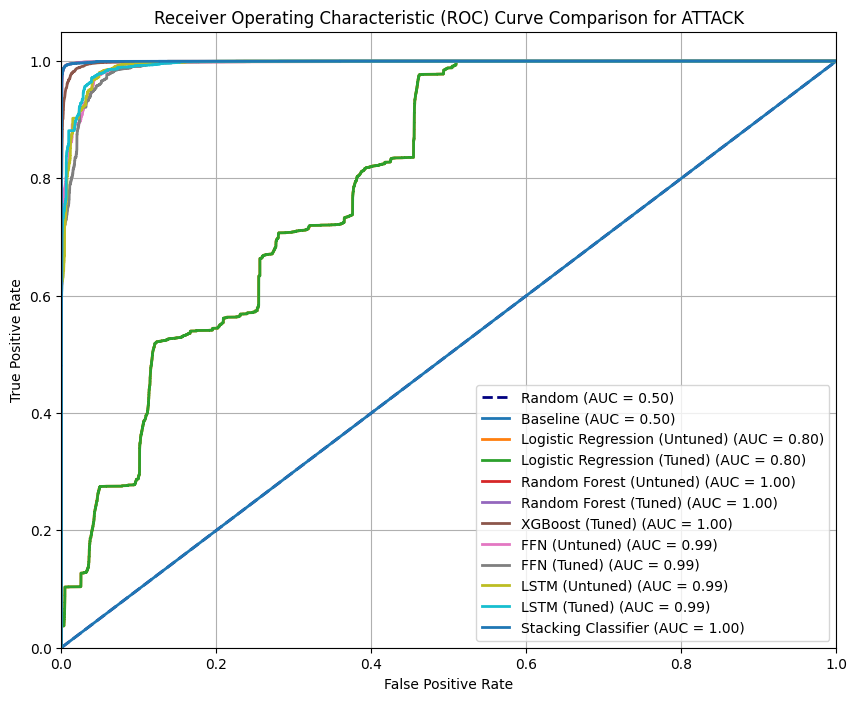

Baseline Average Precision: 0.1968
Logistic Regression (Untuned) Average Precision: 0.4641
Logistic Regression (Tuned) Average Precision: 0.4639
Random Forest (Untuned) Average Precision: 0.9964
Random Forest (Tuned) Average Precision: 0.9973
XGBoost (Tuned) Average Precision: 0.9952
FFN (Untuned) Average Precision: 0.9757
FFN (Tuned) Average Precision: 0.9692
LSTM (Untuned) Average Precision: 0.9749
LSTM (Tuned) Average Precision: 0.9784
Stacking Classifier Average Precision: 0.9979


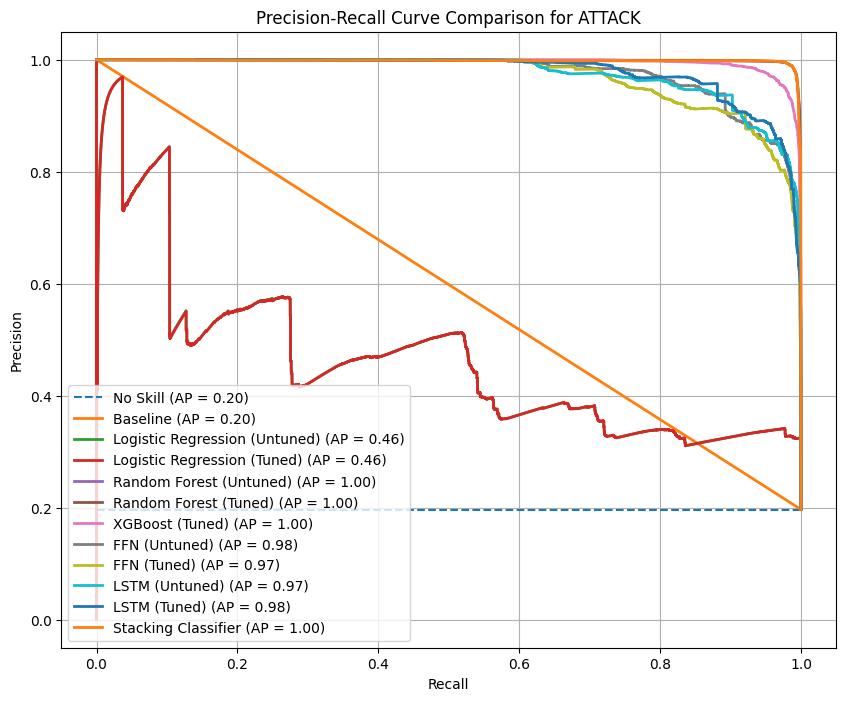


--- Summary of Model Performance (F1-score for Positive Class) ---
Stacking Classifier: F1-score (Positive Class) = 0.9864
Random Forest (Tuned): F1-score (Positive Class) = 0.9862
Random Forest (Untuned): F1-score (Positive Class) = 0.9862
XGBoost (Tuned): F1-score (Positive Class) = 0.9567
LSTM (Tuned): F1-score (Positive Class) = 0.9018
FFN (Untuned): F1-score (Positive Class) = 0.8924
LSTM (Untuned): F1-score (Positive Class) = 0.8921
FFN (Tuned): F1-score (Positive Class) = 0.8713
Logistic Regression (Untuned): F1-score (Positive Class) = 0.4655
Logistic Regression (Tuned): F1-score (Positive Class) = 0.4654
Baseline: F1-score (Positive Class) = 0.0000

--- Summary of Model Performance (ROC AUC) ---
Stacking Classifier: ROC AUC = 0.9995
Random Forest (Tuned): ROC AUC = 0.9991
Random Forest (Untuned): ROC AUC = 0.9989
XGBoost (Tuned): ROC AUC = 0.9987
LSTM (Tuned): ROC AUC = 0.9942
LSTM (Untuned): ROC AUC = 0.9936
FFN (Untuned): ROC AUC = 0.9934
FFN (Tuned): ROC AUC = 0.9919
Logis

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
import numpy as np
import os
import joblib
import pickle
import optuna
import matplotlib.pyplot as plt

# Ensure checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# --- Load final_label_encoder for Classification Reports ---
final_label_encoder = None
positive_class_name = "ATTACK" # Default value; will be updated if label encoder is loaded
try:
    with open(os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl"), "rb") as f:
        final_label_encoder = pickle.load(f)
    print("Loaded final_label_encoder for current stage.")
    # Set positive_class_name based on the loaded encoder
    positive_class_name = final_label_encoder.classes_[1]
except FileNotFoundError:
    print(f"Warning: 'final_binary_label_encoder.pkl' not found at {os.path.join(checkpoint_dir, 'final_binary_label_encoder.pkl')}. Classification reports may use default labels.")
except Exception as e:
    print(f"An unexpected error occurred while loading final_label_encoder: {e}")

# Pre-calculate unique labels and filtered target names for classification_report
if final_label_encoder is not None:
    unique_test_labels = np.unique(y_test)
    label_mapping = {i: name for i, name in enumerate(final_label_encoder.classes_)}
    filtered_target_names = [label_mapping[label] for label in sorted(unique_test_labels)]
else:
    print("Warning: final_label_encoder not available. Classification reports may use default labels (0, 1).")
    unique_test_labels = np.unique(y_test)
    filtered_target_names = [str(label) for label in sorted(unique_test_labels)]

# --- Define FFN Model Classes (Matching Saved Architectures) ---
class FFN_Untuned(nn.Module):
    def __init__(self, input_dim):
        super(FFN_Untuned, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class FFN_Tuned(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.0):
        super(FFN_Tuned, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# --- Define LSTM Model Classes (Matching Saved Architectures) ---
class LSTMNet_Untuned(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMNet_Untuned, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

class LSTMNet_Tuned(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0):
        super(LSTMNet_Tuned, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

print("\n--- Model Comparison and Selection ---")

# --- Load all required models and pipelines for comparison ---
loaded_models = {}

# Dummy Classifier
try:
    dummy_model = joblib.load(os.path.join(checkpoint_dir, "dummy_binary_model.pkl"))
    loaded_models['Baseline'] = dummy_model
except FileNotFoundError:
    print("Warning: dummy_binary_model.pkl not found. Skipping Dummy Classifier.")

# Untuned Logistic Regression
try:
    pipeline_lr = joblib.load(os.path.join(checkpoint_dir, "logistic_regression_binary_pipeline.pkl"))
    loaded_models['Logistic Regression (Untuned)'] = pipeline_lr
except FileNotFoundError:
    print("Warning: logistic_regression_binary_pipeline.pkl not found. Skipping Untuned LR.")

# Tuned Logistic Regression
try:
    best_lr_model_pipeline = joblib.load(os.path.join(checkpoint_dir, "tuned_logistic_regression_binary_pipeline.pkl"))
    loaded_models['Logistic Regression (Tuned)'] = best_lr_model_pipeline
except FileNotFoundError:
    print("Warning: tuned_logistic_regression_binary_pipeline.pkl not found. Skipping Tuned LR.")

# Untuned Random Forest
try:
    pipeline_rf = joblib.load(os.path.join(checkpoint_dir, "random_forest_binary_pipeline.pkl"))
    loaded_models['Random Forest (Untuned)'] = pipeline_rf
except FileNotFoundError:
    print("Warning: random_forest_binary_pipeline.pkl not found. Skipping Untuned RF.")

# Tuned Random Forest
try:
    best_rf_model_pipeline = joblib.load(os.path.join(checkpoint_dir, "tuned_random_forest_binary_pipeline.pkl"))
    loaded_models['Random Forest (Tuned)'] = best_rf_model_pipeline
except FileNotFoundError:
    print("Warning: tuned_random_forest_binary_pipeline.pkl not found. Skipping Tuned RF.")

# Tuned XGBoost
try:
    best_xgb_model_pipeline = joblib.load(os.path.join(checkpoint_dir, "tuned_xgboost_binary_pipeline.pkl"))
    loaded_models['XGBoost (Tuned)'] = best_xgb_model_pipeline
except FileNotFoundError:
    print("Warning: tuned_xgboost_binary_pipeline.pkl not found. Skipping Tuned XGBoost.")

# --- FFN Models (Untuned and Tuned) ---
try:
    ffn_untuned_model = FFN_Untuned(X_test_processed.shape[1]).to(device)
    ffn_untuned_model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "ffn_binary_model_state_dict.pth"), map_location=device))
    loaded_models['FFN (Untuned)'] = ffn_untuned_model
except FileNotFoundError:
    print("Warning: ffn_binary_model_state_dict.pth (Untuned FFN) not found. Skipping Untuned FFN.")
except RuntimeError as e:
    print(f"Error loading Untuned FFN state_dict: {e}. Check if FFN_Untuned architecture matches saved model.")

try:
    ffn_tuned_dropout_rate = 0.0
    try:
        ffn_params_path = os.path.join(checkpoint_dir, "best_params_ffn.pkl")
        if os.path.exists(ffn_params_path):
            with open(ffn_params_path, 'rb') as f:
                ffn_best_params_loaded = pickle.load(f)
            ffn_tuned_dropout_rate = ffn_best_params_loaded.get('dropout_rate', 0.0)
            print(f"Loaded FFN Tuned Dropout Rate from file: {ffn_tuned_dropout_rate}")
        elif 'study' in locals() and hasattr(study, 'best_params'):
            ffn_tuned_dropout_rate = study.best_params.get('dropout_rate', 0.0)
            print(f"Using FFN Tuned Dropout Rate from study: {ffn_tuned_dropout_rate}")
    except Exception as e:
        print(f"Error retrieving FFN best_params for dropout: {e}. Using default 0.0.")

    ffn_tuned_model = FFN_Tuned(X_test_processed.shape[1], dropout_rate=ffn_tuned_dropout_rate).to(device)
    ffn_tuned_model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "ffn_binary_model_state_dict_optuna_tuned.pth"), map_location=device))
    loaded_models['FFN (Tuned)'] = ffn_tuned_model
except FileNotFoundError:
    print("Warning: ffn_binary_model_state_dict_optuna_tuned.pth (Tuned FFN) not found. Skipping Tuned FFN.")
except RuntimeError as e:
    print(f"Error loading Tuned FFN state_dict: {e}. Check if FFN_Tuned architecture matches saved model (especially input_dim and dropout).")


# Recurrent Neural Network (LSTM) - Untuned
try:
    lstm_untuned_model = LSTMNet_Untuned(input_dim=1, hidden_dim=64, num_layers=1).to(device)
    lstm_untuned_model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "lstm_binary_model_state_dict.pth"), map_location=device))
    loaded_models['LSTM (Untuned)'] = lstm_untuned_model
except FileNotFoundError:
    print("Warning: lstm_binary_model_state_dict.pth (Untuned LSTM) not found. Skipping Untuned LSTM.")
except RuntimeError as e:
    print(f"Error loading Untuned LSTM state_dict: {e}. This likely means the architecture for LSTMNet_Untuned does not precisely match the saved model.")


# Recurrent Neural Network (LSTM) - Tuned
try:
    lstm_tuned_dropout_rate = 0.0
    lstm_tuned_hidden_dim = 64
    lstm_tuned_num_layers = 1
    
    try:
        lstm_params_path = os.path.join(checkpoint_dir, "best_params_lstm.pkl")
        if os.path.exists(lstm_params_path):
            with open(lstm_params_path, "rb") as f:
                best_params_lstm_loaded = pickle.load(f)
            lstm_tuned_dropout_rate = best_params_lstm_loaded.get('dropout_rate', 0.0)
            lstm_tuned_hidden_dim = best_params_lstm_loaded.get('hidden_dim', 64)
            lstm_tuned_num_layers = best_params_lstm_loaded.get('num_layers', 1)
            print(f"Loaded LSTM Tuned Parameters: Hidden Dim={lstm_tuned_hidden_dim}, Num Layers={lstm_tuned_num_layers}, Dropout Rate={lstm_tuned_dropout_rate}")
        elif 'study_lstm' in locals() and hasattr(study_lstm, 'best_params'):
            best_params_lstm_from_study = study_lstm.best_params
            lstm_tuned_dropout_rate = best_params_lstm_from_study.get('dropout_rate', 0.0)
            lstm_tuned_hidden_dim = best_params_lstm_from_study.get('hidden_dim', 64)
            lstm_tuned_num_layers = best_params_lstm_from_study.get('num_layers', 1)
            print(f"Using LSTM Tuned Parameters from study: Hidden Dim={lstm_tuned_hidden_dim}, Num Layers={lstm_tuned_num_layers}, Dropout Rate={lstm_tuned_dropout_rate}")
    except Exception as e:
        print(f"Error retrieving LSTM best_params: {e}. Using default parameters.")

    lstm_tuned_model = LSTMNet_Tuned(
        input_dim=1,
        hidden_dim=lstm_tuned_hidden_dim,
        num_layers=lstm_tuned_num_layers,
        dropout_rate=lstm_tuned_dropout_rate
    ).to(device)

    lstm_tuned_model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "lstm_binary_model_state_dict_optuna_tuned.pth"), map_location=device))
    loaded_models['LSTM (Tuned)'] = lstm_tuned_model
except FileNotFoundError:
    print("Warning: lstm_binary_model_state_dict_optuna_tuned.pth (Tuned LSTM) not found. Skipping Tuned LSTM.")
except RuntimeError as e:
    print(f"Error loading Tuned LSTM state_dict: {e}. This likely means the architecture for LSTMNet_Tuned does not precisely match the saved model (especially hidden_dim, num_layers, dropout).")


# Stacking Classifier
try:
    stacked_classifier = joblib.load(os.path.join(checkpoint_dir, "stacked_binary_classifier.pkl"))
    loaded_models['Stacking Classifier'] = stacked_classifier
except FileNotFoundError:
    print("Warning: stacked_binary_classifier.pkl not found. Skipping Stacking Classifier.")


# Dictionary to store performance metrics for comparison (F1-score of positive class)
model_performance = {}
model_probabilities = {}

# Convert X_test_processed to tensor once for all PyTorch models
X_test_tensor_pytorch = torch.tensor(X_test_processed, dtype=torch.float32).to(device)


# --- Evaluate and Collect F1-scores and Probabilities for all models ---
for model_name, model_instance in loaded_models.items():
    y_pred = None
    y_prob_pos_class = None

    try:
        # Scikit-learn models (including Pipelines, Dummy, LR, RF, Stacking)
        if isinstance(model_instance, (Pipeline, DummyClassifier, LogisticRegression, RandomForestClassifier, StackingClassifier)):
            y_pred = model_instance.predict(X_test_processed)
            if hasattr(model_instance, 'predict_proba'):
                y_prob_pos_class = model_instance.predict_proba(X_test_processed)[:, 1]
            else:
                print(f"Warning: Scikit-learn model '{model_name}' does not have 'predict_proba'. ROC/PR curves will be skipped for it.")
        # FFN models (using the new class names FFN_Untuned and FFN_Tuned)
        elif isinstance(model_instance, (FFN_Untuned, FFN_Tuned)):
            model_instance.eval()
            with torch.no_grad():
                y_pred_logits = model_instance(X_test_tensor_pytorch).cpu().squeeze(1)
                y_prob_pos_class = torch.sigmoid(y_pred_logits).numpy()
                y_pred = (y_prob_pos_class >= 0.5).astype(int)
        # LSTM models
        elif isinstance(model_instance, (LSTMNet_Untuned, LSTMNet_Tuned)):
            model_instance.eval()
            with torch.no_grad():
                y_pred_logits = model_instance(X_test_tensor_pytorch).cpu().squeeze(1)
                y_prob_pos_class = torch.sigmoid(y_pred_logits).numpy()
                y_pred = (y_prob_pos_class >= 0.5).astype(int)
        # Direct XGBoost model (assuming it's not in a pipeline)
        elif isinstance(model_instance, xgb.XGBClassifier):
            y_pred = model_instance.predict(X_test_processed)
            y_prob_pos_class = model_instance.predict_proba(X_test_processed)[:, 1]
        else:
            print(f"Warning: Model type {type(model_instance).__name__} for '{model_name}' not recognized for evaluation. Skipping.")
            continue

        if y_pred is not None:
            f1_score_current = f1_score(y_test, y_pred, average='binary', zero_division=0)
            model_performance[model_name] = f1_score_current
            print(f"{model_name} Test F1-score (Positive Class): {f1_score_current:.4f}")
            
        if y_prob_pos_class is not None:
            model_probabilities[model_name] = y_prob_pos_class
        else:
            print(f"Note: No probabilities stored for '{model_name}'. ROC/PR plots will skip it.")

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}. Skipping its performance metrics and plots.")

# --- Comparative ROC and Precision-Recall Curves ---
print("\n--- Comparative ROC and Precision-Recall Curves ---")

try:
    # Store AUC/AP scores for summary
    roc_auc_scores = {}
    pr_ap_scores = {}

    # --- ROC Curve Plotting ---
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')

    for model_name, y_prob_pos_class in model_probabilities.items():
        if y_prob_pos_class is not None and len(y_prob_pos_class) > 0:
            try:
                fpr, tpr, _ = roc_curve(y_test, y_prob_pos_class)
                roc_auc = auc(fpr, tpr)
                roc_auc_scores[model_name] = roc_auc
                print(f"{model_name} ROC AUC: {roc_auc:.4f}")
                plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
            except ValueError as e:
                print(f"Could not calculate ROC for {model_name}: {e}")
        else:
            print(f"Skipping ROC plot for {model_name} due to missing or empty probabilities.")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve Comparison for {positive_class_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # --- Precision-Recall Curve Plotting ---
    plt.figure(figsize=(10, 8))
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill (AP = {no_skill:.2f})')

    for model_name, y_prob_pos_class in model_probabilities.items():
        if y_prob_pos_class is not None and len(y_prob_pos_class) > 0:
            try:
                precision, recall, _ = precision_recall_curve(y_test, y_prob_pos_class)
                ap_score = average_precision_score(y_test, y_prob_pos_class)
                pr_ap_scores[model_name] = ap_score
                print(f"{model_name} Average Precision: {ap_score:.4f}")
                plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {ap_score:.2f})')
            except ValueError as e:
                print(f"Could not calculate PR for {model_name}: {e}")
        else:
            print(f"Skipping PR plot for {model_name} due to missing or empty probabilities.")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve Comparison for {positive_class_name}')
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

except NameError:
    print("\nWarning: Matplotlib or other plotting libraries not available. Skipping plots.")
    # If plots are skipped, still proceed to print the summary tables below
except Exception as e:
    print(f"\nError during plotting: {e}. Skipping plots.")

print("\n--- Summary of Model Performance (F1-score for Positive Class) ---")
sorted_performance = sorted(model_performance.items(), key=lambda item: item[1], reverse=True)
for model_name, f1 in sorted_performance:
    print(f"{model_name}: F1-score (Positive Class) = {f1:.4f}")

print("\n--- Summary of Model Performance (ROC AUC) ---")
sorted_roc_auc = sorted(roc_auc_scores.items(), key=lambda item: item[1], reverse=True)
for model_name, auc_score in sorted_roc_auc:
    print(f"{model_name}: ROC AUC = {auc_score:.4f}")

print("\n--- Summary of Model Performance (Average Precision) ---")
sorted_pr_ap = sorted(pr_ap_scores.items(), key=lambda item: item[1], reverse=True)
for model_name, ap_score in sorted_pr_ap:
    print(f"{model_name}: Average Precision = {ap_score:.4f}")

print("\n--- End Model Comparison and Selection ---")

## 8. Selecting the Best ML Model
This section focuses on Final Model Selection and Detailed Evaluation. It automatically identifies the best-performing model based on the F1-score from the previous comparison stage and loads it. It then generates and saves the predictions and positive class probabilities from this chosen model on the test set. Finally, it provides a comprehensive visual and numerical evaluation of the selected best model, including a classification report, confusion matrix, ROC curve, and Precision-Recall (PR) curve, to illustrate its performance in detail.


Best Model Selected: Stacking Classifier with F1-score (Positive Class): 0.9864
Checkpoint: Best model name saved to ./model_checkpoints/best_binary_model_name.pkl
Checkpoint: Final best model saved to ./model_checkpoints/final_best_binary_model_stacking_classifier.pkl
Checkpoint: Final predictions saved to ./model_checkpoints/final_binary_y_pred.npy
Checkpoint: Final positive class probabilities saved to ./model_checkpoints/final_binary_y_prob_pos_class.npy

--- Final Model Results for Stacking Classifier ---
Classification Report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     45427
      ATTACK       0.98      0.99      0.99     11131

    accuracy                           0.99     56558
   macro avg       0.99      0.99      0.99     56558
weighted avg       0.99      0.99      0.99     56558


Confusion Matrix:


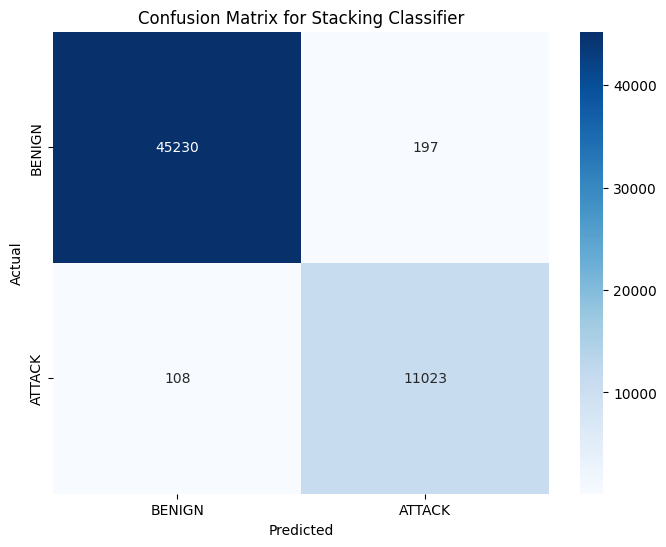

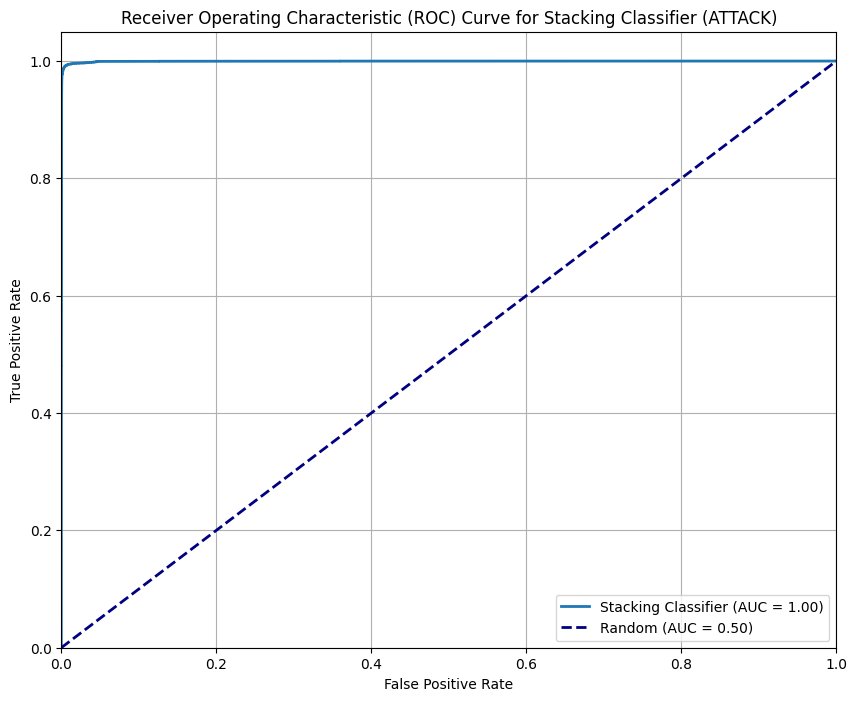

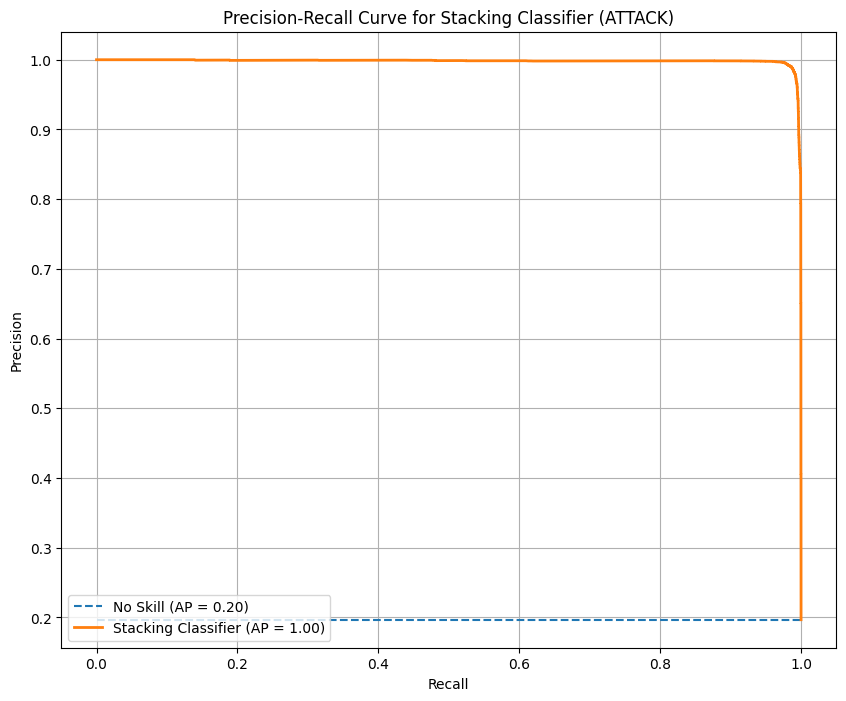

In [27]:
import numpy as np
import torch
import torch.nn as nn # Added for FFN and LSTMNet class definitions
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import pickle

# Ensure these are imported from previous sections or locally
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import xgboost as xgb

# --- Define FFN Model Class (needed for loading state_dict) ---
# This definition must match the one used during training/tuning.
class FFN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.0): # Crucial: Must match FFN tuning's __init__
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1) # Output layer for binary classification (logits)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate) # Dropout layer
        self.dropout2 = nn.Dropout(p=dropout_rate) # Dropout layer

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x) # Apply dropout after ReLU
        x = self.relu(self.fc2(x))
        x = self.dropout2(x) # Apply dropout after ReLU
        x = self.fc3(x) # Output logits
        return x

# --- Define LSTM Model Class (needed for loading state_dict) ---
# This definition must match the one used during training/tuning.
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0): # Crucial: Must match LSTM tuning's __init__
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # input_size should be the feature dimension for each time step.
        # If your X_test_processed is (samples, features) and features are time steps,
        # then input_dim should be 1 if each feature is a single value at a time step.
        # This aligns with `x.unsqueeze(-1)` making it (batch_size, sequence_length, 1).
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_rate) # Dropout layer, added for tuning
        self.fc = nn.Linear(hidden_dim, 1) # Binary classification output

    def forward(self, x):
        # x is assumed to be (batch_size, sequence_length) from X_train_res/X_test_processed
        # unsqueeze(-1) adds the input_size dimension, making it (batch_size, sequence_length, 1)
        x = x.unsqueeze(-1)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :]) # Apply dropout to the last time step output before final FC layer
        out = self.fc(out)
        return out


# Ensure final_label_encoder is available
if 'final_label_encoder' not in locals() or final_label_encoder is None:
    try:
        # Load the binary-specific label encoder
        label_encoder_path = os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl")
        with open(label_encoder_path, "rb") as f:
            final_label_encoder = pickle.load(f)
        print(f"Loaded final_label_encoder from {label_encoder_path} for current stage.")
    except FileNotFoundError:
        print(f"Error: 'final_label_encoder' not found in current scope or at {label_encoder_path}. Please ensure previous stages were run.")
        final_label_encoder = None
    except Exception as e:
        print(f"An unexpected error occurred while loading final_label_encoder: {e}")
        final_label_encoder = None

# Get class names from final_label_encoder for plotting and reports
if final_label_encoder is not None:
    class_names = final_label_encoder.classes_
    if len(class_names) == 2:
        positive_class_name = class_names[1] # Assuming class_names[1] is the positive class
    else:
        print("Warning: LabelEncoder does not contain 2 classes. Defaulting positive_class_name to 'Positive Class'.")
        positive_class_name = "Positive Class" # Fallback
else:
    print("Warning: final_label_encoder not available. Inferring class names from y_test and using generic names.")
    unique_labels_in_test = sorted(np.unique(y_test)) if 'y_test' in locals() else [0, 1]
    class_names = [f"Class {i}" for i in unique_labels_in_test]
    positive_class_name = "Class 1" # Default to 'Class 1' as positive


# --- Select the best model based on F1-score ---
if 'model_performance' in locals() and model_performance:
    # Ensure model_performance keys are consistent with what's being loaded
    best_model_name = max(model_performance, key=model_performance.get)
    print(f"\nBest Model Selected: {best_model_name} with F1-score (Positive Class): {model_performance[best_model_name]:.4f}")

    # Checkpoint 1: Save the best_model_name
    best_model_name_path = os.path.join(checkpoint_dir, "best_binary_model_name.pkl")
    joblib.dump(best_model_name, best_model_name_path)
    print(f"Checkpoint: Best model name saved to {best_model_name_path}")
else:
    best_model_name = "N/A"
    print("\nWarning: 'model_performance' not found or is empty. Cannot select best model.")


# Assign final_model based on the best_model_name for subsequent plotting
final_model = None

# --- Load the selected best model ---
if best_model_name != "N/A":
    try:
        if best_model_name == 'Baseline':
            final_model = joblib.load(os.path.join(checkpoint_dir, "dummy_binary_model.pkl"))
        elif best_model_name == 'Logistic Regression (Untuned)':
            final_model = joblib.load(os.path.join(checkpoint_dir, "logistic_regression_binary_pipeline.pkl"))
        elif best_model_name == 'Logistic Regression (Tuned)':
            final_model = joblib.load(os.path.join(checkpoint_dir, "tuned_logistic_regression_binary_pipeline.pkl"))
        elif best_model_name == 'Random Forest (Untuned)':
            final_model = joblib.load(os.path.join(checkpoint_dir, "random_forest_binary_pipeline.pkl"))
        elif best_model_name == 'Random Forest (Tuned)':
            final_model = joblib.load(os.path.join(checkpoint_dir, "tuned_random_forest_binary_pipeline.pkl"))
        elif best_model_name == 'XGBoost (Tuned)':
            final_model = joblib.load(os.path.join(checkpoint_dir, "tuned_xgboost_binary_pipeline.pkl"))
        elif best_model_name == 'FFN (Untuned)':
            if 'X_test_processed' not in locals():
                raise ValueError("X_test_processed is required to instantiate FFN model but not found.")
            # Untuned FFN did not use dropout during its base training, so dropout_rate=0.0
            ffn_model_loaded = FFN(X_test_processed.shape[1], dropout_rate=0.0).to(device)
            ffn_model_loaded.load_state_dict(torch.load(os.path.join(checkpoint_dir, "ffn_binary_model_state_dict.pth"), map_location=device))
            final_model = ffn_model_loaded
        elif best_model_name == 'FFN (Tuned)':
            if 'X_test_processed' not in locals():
                raise ValueError("X_test_processed is required to instantiate Tuned FFN model but not found.")
            # For loading, if the exact tuned dropout rate isn't available from a global variable (e.g., study.best_params),
            # you might need to load it from a separate config file or re-run the tuning block.
            # Using a sensible default (0.0) or assuming it's hardcoded if not passed.
            # Ideally, the best_params_ffn from tuning would be passed here.
            # Let's assume you've retrieved `ffn_tuned_dropout_rate` from the prior cell or it's a global var.
            # If not, you might need to uncomment and adapt the loading logic from the previous block here.
            ffn_tuned_dropout_rate = 0.0 # Placeholder, adjust if you load actual best_params
            try:
                # If the FFN tuning cell was run immediately before this, `study.best_params` might be in scope.
                if 'study' in locals() and hasattr(study, 'best_params'):
                    ffn_tuned_dropout_rate = study.best_params.get('dropout_rate', 0.0)
            except NameError: # study not found
                pass
            except Exception as e: # Other errors getting params
                print(f"Error getting FFN tuned dropout rate: {e}. Using default 0.0.")

            ffn_tuned_model_loaded = FFN(X_test_processed.shape[1], dropout_rate=ffn_tuned_dropout_rate).to(device)
            ffn_tuned_model_loaded.load_state_dict(torch.load(os.path.join(checkpoint_dir, "ffn_binary_model_state_dict_optuna_tuned.pth"), map_location=device))
            final_model = ffn_tuned_model_loaded
        elif best_model_name == 'LSTM (Untuned)': # Renamed for clarity
            if 'X_test_processed' not in locals():
                raise ValueError("X_test_processed is required to instantiate LSTM model but not found.")
            # Untuned LSTM fixed hidden_dim=64, num_layers=1, and no dropout (0.0)
            lstm_untuned_model_loaded = LSTMNet(input_dim=1, hidden_dim=64, num_layers=1, dropout_rate=0.0).to(device)
            lstm_untuned_model_loaded.load_state_dict(torch.load(os.path.join(checkpoint_dir, "lstm_binary_model_state_dict.pth"), map_location=device))
            final_model = lstm_untuned_model_loaded
        elif best_model_name == 'LSTM (Tuned)': # NEW: Handling the tuned LSTM
            if 'X_test_processed' not in locals():
                raise ValueError("X_test_processed is required to instantiate Tuned LSTM model but not found.")
            
            # Need to retrieve the exact hidden_dim, num_layers, and dropout_rate used for the best tuned LSTM
            # These are FIXED_HIDDEN_DIM_LSTM and FIXED_NUM_LAYERS_LSTM in the tuning script,
            # and `best_params_lstm['dropout_rate']` from the tuning study.
            # Assuming FIXED_HIDDEN_DIM_LSTM and FIXED_NUM_LAYERS_LSTM are globally available or hardcoded.
            # If `study_lstm.best_params` is in scope from the tuning cell, use that.
            lstm_tuned_dropout_rate = 0.0 # Default if not found
            lstm_tuned_hidden_dim = 64 # Default (from tuning script's FIXED_HIDDEN_DIM_LSTM)
            lstm_tuned_num_layers = 1 # Default (from tuning script's FIXED_NUM_LAYERS_LSTM)

            try:
                if 'study_lstm' in locals() and hasattr(study_lstm, 'best_params'):
                    best_params_lstm_from_study = study_lstm.best_params
                    lstm_tuned_dropout_rate = best_params_lstm_from_study.get('dropout_rate', 0.0)
                    # If you chose to tune these, uncomment and retrieve them:
                    # lstm_tuned_hidden_dim = best_params_lstm_from_study.get('hidden_dim', FIXED_HIDDEN_DIM_LSTM)
                    # lstm_tuned_num_layers = best_params_lstm_from_study.get('num_layers', FIXED_NUM_LAYERS_LSTM)
            except NameError: # study_lstm not found
                pass
            except Exception as e: # Other errors getting params
                print(f"Error getting LSTM tuned parameters: {e}. Using defaults.")

            lstm_tuned_model_loaded = LSTMNet(
                input_dim=1, # Fixed as per LSTMNet definition
                hidden_dim=lstm_tuned_hidden_dim,
                num_layers=lstm_tuned_num_layers,
                dropout_rate=lstm_tuned_dropout_rate # Use the tuned dropout rate
            ).to(device)
            lstm_tuned_model_loaded.load_state_dict(torch.load(os.path.join(checkpoint_dir, "lstm_binary_model_state_dict_optuna_tuned.pth"), map_location=device))
            final_model = lstm_tuned_model_loaded
        elif best_model_name == 'Stacking Classifier':
            final_model = joblib.load(os.path.join(checkpoint_dir, "stacked_binary_classifier.pkl"))
        else:
            print(f"Error: Unrecognized best model name '{best_model_name}'.")

    except FileNotFoundError as e:
        print(f"Error loading {best_model_name}: {e}. Model file not found.")
        final_model = None
    except Exception as e:
        print(f"An unexpected error occurred while loading {best_model_name}: {e}")
        final_model = None

if final_model is None:
    print(f"Could not load the selected best model: {best_model_name}. Skipping subsequent analysis.")


# Checkpoint 2: Save the final_model object
if final_model is not None:
    # Use a generic, versioned name or the specific best model name
    final_model_filename = f"final_best_binary_model_{best_model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}" # Sanitize filename

    if isinstance(final_model, (Pipeline, DummyClassifier, LogisticRegression, RandomForestClassifier, xgb.XGBClassifier, StackingClassifier)):
        final_model_path = os.path.join(checkpoint_dir, final_model_filename + ".pkl")
        try:
            joblib.dump(final_model, final_model_path)
            print(f"Checkpoint: Final best model saved to {final_model_path}")
        except Exception as e:
            print(f"Error saving Scikit-learn type model: {e}")
    elif isinstance(final_model, (FFN, LSTMNet)):
        final_model_path = os.path.join(checkpoint_dir, final_model_filename + "_state_dict.pth")
        try:
            torch.save(final_model.state_dict(), final_model_path)
            print(f"Checkpoint: Final best PyTorch model state_dict saved to {final_model_path}")
        except Exception as e:
            print(f"Error saving PyTorch model state_dict: {e}")
    else:
        print("Warning: Final model type not recognized for explicit checkpointing. Skipping final model save.")
else:
    print("Skipping final model checkpointing as final_model is None.")


# --- Determine final_y_pred and final_y_prob for the selected best_model ---
final_y_pred = None
final_y_prob_pos_class = None # Store only the probability of the positive class

if final_model is not None and 'X_test_processed' in locals() and 'y_test' in locals():
    # Handle Scikit-learn type models (including Pipelines, StackingClassifier, etc.)
    if isinstance(final_model, (Pipeline, DummyClassifier, LogisticRegression, RandomForestClassifier, xgb.XGBClassifier, StackingClassifier)):
        final_y_pred = final_model.predict(X_test_processed)
        if hasattr(final_model, 'predict_proba'):
            final_y_prob_pos_class = final_model.predict_proba(X_test_processed)[:, 1] # Extract positive class probability
        else:
            print(f"Warning: Model type {type(final_model).__name__} does not support predict_proba. ROC/PR curves will be skipped.")
            final_y_prob_pos_class = None
    # Handle PyTorch models
    elif isinstance(final_model, (FFN, LSTMNet)):
        final_model.eval() # Ensure in eval mode
        with torch.no_grad():
            X_test_tensor_final = torch.tensor(X_test_processed, dtype=torch.float32).to(device)

            if isinstance(final_model, LSTMNet):
                # Ensure input to LSTM is (batch_size, sequence_length, input_size)
                # X_test_processed is (samples, sequence_length) based on prior usage,
                # input_size for LSTMNet is fixed to 1.
                X_test_tensor_final = X_test_tensor_final.unsqueeze(-1) # Add last dimension for input_size=1

            y_pred_logits_final = final_model(X_test_tensor_final).cpu().squeeze(1) # Squeeze to 1D
            final_y_prob_pos_class = torch.sigmoid(y_pred_logits_final).numpy() # Sigmoid for binary probability
            final_y_pred = (final_y_prob_pos_class >= 0.5).astype(int)
    else:
        print(f"Warning: Final model type {type(final_model).__name__} not recognized for final prediction and plotting.")
else:
    print("Cannot generate final predictions/probabilities: final_model, X_test_processed, or y_test is missing.")

# Checkpoint 3: Save final predictions and probabilities
if final_y_pred is not None:
    final_y_pred_path = os.path.join(checkpoint_dir, "final_binary_y_pred.npy")
    np.save(final_y_pred_path, final_y_pred)
    print(f"Checkpoint: Final predictions saved to {final_y_pred_path}")

if final_y_prob_pos_class is not None:
    final_y_prob_path = os.path.join(checkpoint_dir, "final_binary_y_prob_pos_class.npy")
    np.save(final_y_prob_path, final_y_prob_pos_class)
    print(f"Checkpoint: Final positive class probabilities saved to {final_y_prob_path}")


# --- Proceed with Final Model Results Plotting ---

print(f"\n--- Final Model Results for {best_model_name} ---")

if final_y_pred is not None and 'y_test' in locals() and class_names is not None:
    print("Classification Report:")
    print(classification_report(y_test, final_y_pred, target_names=class_names, zero_division=0))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, final_y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {best_model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if final_y_prob_pos_class is not None:
        # ROC Curve (Binary Classification)
        plt.figure(figsize=(10, 8))
        fpr, tpr, _ = roc_curve(y_test, final_y_prob_pos_class)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f'{best_model_name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve for {best_model_name} ({positive_class_name})')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

        # Precision-Recall Curve (Binary Classification)
        plt.figure(figsize=(10, 8))
        precision, recall, _ = precision_recall_curve(y_test, final_y_prob_pos_class)
        ap_score = average_precision_score(y_test, final_y_prob_pos_class)

        # Plot no-skill line (fraction of positive cases)
        no_skill = len(y_test[y_test==1]) / len(y_test) if len(y_test) > 0 else 0.5 # Avoid division by zero
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill (AP = {no_skill:.2f})')

        plt.plot(recall, precision, lw=2, label=f'{best_model_name} (AP = {ap_score:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for {best_model_name} ({positive_class_name})')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.show()
    else:
        print("\nCould not generate ROC and PR curves as probability predictions for the positive class are not available for the final model.")
else:
    print("Final model prediction failed or plotting skipped due to missing data (final_y_pred, y_test, or class_names).")

## 9. Model Interpretation
This section focuses on Model Interpretability, specifically using SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations) to understand how the selected best model makes its predictions.


--- Model Interpretation (SHAP Explanations) ---

--- SHAP Interpretation for Stacking Classifier (Model-Agnostic KernelExplainer) ---


  0%|          | 0/100 [00:00<?, ?it/s]

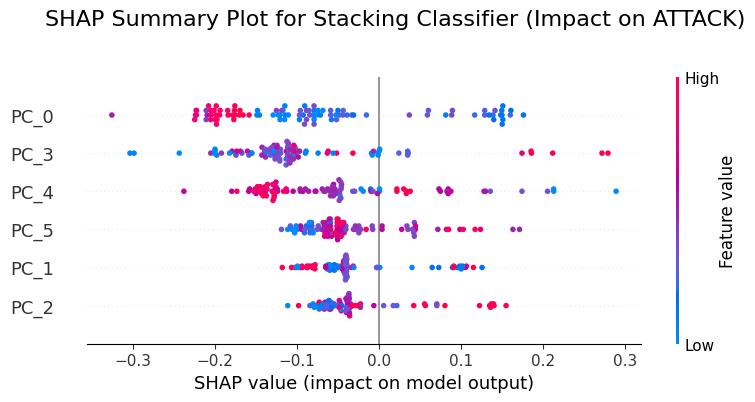

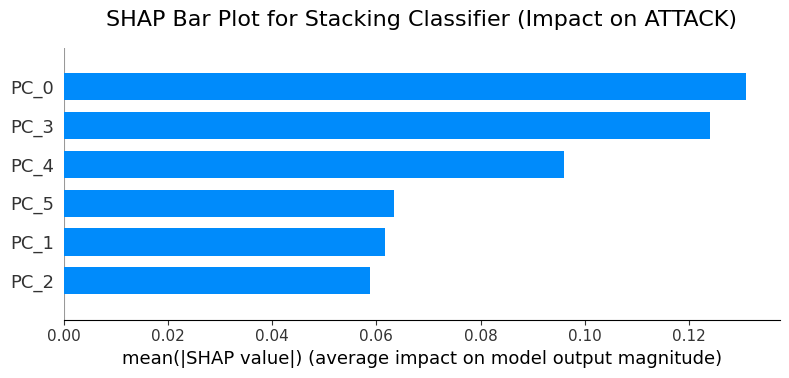


--- Mapping PCA Component Importance back to Original Features ---
Top 10 most important original features for the 'ATTACK' class:
1. bwd packet length min: 0.1778
2. psh flag count: 0.1586
3. init_win_bytes_forward: 0.1505
4. down/up ratio: 0.1496
5. ack flag count: 0.1486
6. min packet length: 0.1312
7. average packet size: 0.0852
8. packet length mean: 0.0773
9. packet length std: 0.0617
10. max packet length: 0.0607


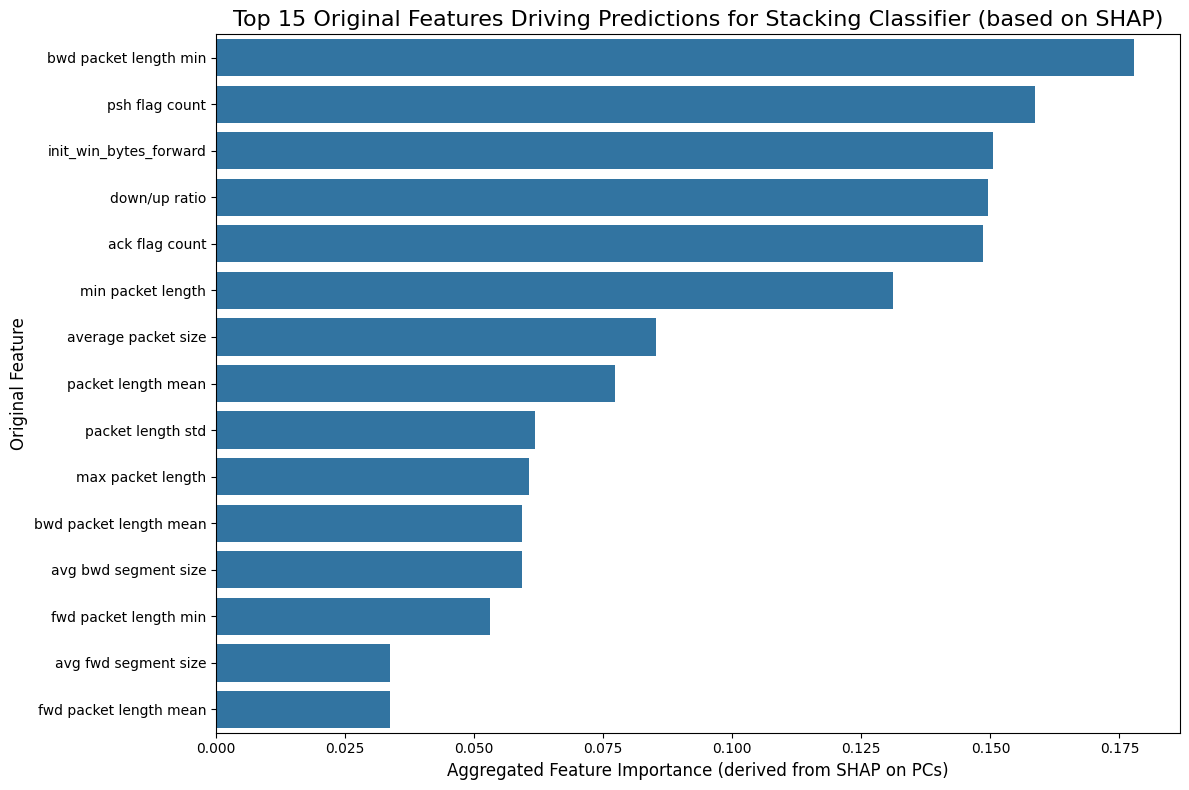

--- End SHAP Explanations ---


In [29]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from lime import lime_tabular
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.dummy import DummyClassifier
import os
import joblib
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA  # New import for PCA interpretation

# --- IMPORTANT: Ensure these global variables are defined in your environment ---
# X_test_processed: Your processed test features (NumPy array or Pandas DataFrame)
# y_test: Your test labels (NumPy array or Pandas Series)
# X_train_processed: Your processed training features (NumPy array or Pandas DataFrame) - used for SHAP background/LIME
# y_train: Your training labels (NumPy array or Pandas Series) - used for dummy model fit
# device: torch.device("cuda" if torch.cuda.is_available() else "cpu")
# checkpoint_dir: A string path to your checkpoint directory (e.g., "./model_checkpoints")
# SEED: An integer for random state initialization (e.g., 42)
#
# NEW: Ensure these are defined for PCA interpretation
# pca_model: The fitted PCA model object used to transform the data.
# original_feature_names: A list of strings with the names of the original features.
#
# Ensure best_params_ffn and best_params_lstm (from Optuna tuning) are accessible here if you want to
# instantiate the models with the exact tuned hyperparameters. Otherwise, a sensible default or hardcoded
# value will be used for instantiation before loading the state_dict.

# --- Define FFN Model Class (needed for loading state_dict) ---
class FFN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.0):
        super(FFN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# --- Define LSTM Model Class (needed for loading state_dict) ---
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(-1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out


# --- Ensure final_label_encoder is available ---
if 'final_label_encoder' not in locals():
    try:
        with open(os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl"), "rb") as f:
            final_label_encoder = pickle.load(f)
        print("Loaded final_binary_label_encoder for current stage.")
    except FileNotFoundError:
        print("Error: 'final_binary_label_encoder.pkl' not found. Please ensure previous stages were run and saved the binary label encoder.")
        print("Attempting to create a dummy LabelEncoder for 'Class 0', 'Class 1'.")
        final_label_encoder = LabelEncoder()
        final_label_encoder.fit(['Class 0', 'Class 1'])
    except Exception as e:
        print(f"An unexpected error occurred while loading final_label_encoder: {e}")
        print("Attempting to create a dummy LabelEncoder for 'Class 0', 'Class 1'.")
        final_label_encoder = LabelEncoder()
        final_label_encoder.fit(['Class 0', 'Class 1'])

if final_label_encoder is not None:
    class_names = final_label_encoder.classes_
    if len(class_names) == 2:
        positive_class_index = 1
        positive_class_name = class_names[positive_class_index]
    else:
        print(f"Warning: Expected 2 classes for binary classification, but found {len(class_names)}. Using default positive class index 1.")
        positive_class_index = 1
        positive_class_name = class_names[1] if len(class_names) > 1 else "Positive Class"
else:
    print("Warning: final_label_encoder not available. Inferring class names as ['Class 0', 'Class 1'] for interpretation.")
    class_names = ['Class 0', 'Class 1']
    positive_class_index = 1
    positive_class_name = "Class 1"

# --- Load final_model and best_model_name if not already in scope ---
if 'final_model' not in locals() or final_model is None:
    try:
        best_model_name_path = os.path.join(checkpoint_dir, "best_binary_model_name.pkl")
        best_model_name = joblib.load(best_model_name_path)
        print(f"Loaded best_model_name: {best_model_name}")

        model_filename_base = f"final_best_binary_model_{best_model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()}"

        if best_model_name.startswith('FFN') or best_model_name.startswith('LSTM'):
            final_model_path = os.path.join(checkpoint_dir, model_filename_base + "_state_dict.pth")
            if best_model_name == 'FFN (Untuned)':
                final_model = FFN(X_test_processed.shape[1], dropout_rate=0.0).to(device)
            elif best_model_name == 'FFN (Tuned)':
                tuned_dropout_rate_ffn = 0.0
                if 'best_params_ffn' in locals() and 'dropout_rate' in best_params_ffn:
                    tuned_dropout_rate_ffn = best_params_ffn['dropout_rate']
                print(f"Instantiating Tuned FFN with dropout_rate={tuned_dropout_rate_ffn}")
                final_model = FFN(X_test_processed.shape[1], dropout_rate=tuned_dropout_rate_ffn).to(device)
            elif best_model_name == 'LSTM (Untuned)':
                final_model = LSTMNet(input_dim=1, hidden_dim=64, num_layers=1, dropout_rate=0.0).to(device)
            elif best_model_name == 'LSTM (Tuned)':
                tuned_hidden_dim_lstm = 64
                tuned_num_layers_lstm = 1
                tuned_dropout_rate_lstm = 0.0
                if 'best_params_lstm' in locals():
                    tuned_hidden_dim_lstm = best_params_lstm.get('hidden_dim', tuned_hidden_dim_lstm)
                    tuned_num_layers_lstm = best_params_lstm.get('num_layers', tuned_num_layers_lstm)
                    tuned_dropout_rate_lstm = best_params_lstm.get('dropout_rate', tuned_dropout_rate_lstm)
                else:
                    print("Warning: 'best_params_lstm' not found in scope. Using default LSTM hyperparameters for instantiation.")
                print(f"Instantiating Tuned LSTM with hidden_dim={tuned_hidden_dim_lstm}, num_layers={tuned_num_layers_lstm}, dropout_rate={tuned_dropout_rate_lstm}")
                final_model = LSTMNet(
                    input_dim=1,
                    hidden_dim=tuned_hidden_dim_lstm,
                    num_layers=tuned_num_layers_lstm,
                    dropout_rate=tuned_dropout_rate_lstm
                ).to(device)
            else:
                raise ValueError(f"Unknown PyTorch model name: {best_model_name}")
            final_model.load_state_dict(torch.load(final_model_path, map_location=device))
            final_model.eval()
        else:
            final_model_path = os.path.join(checkpoint_dir, model_filename_base + ".pkl")
            final_model = joblib.load(final_model_path)
        print(f"Loaded final_model from {final_model_path}")
    except FileNotFoundError as e:
        print(f"Error loading final_model or best_model_name: {e}. Ensure previous stages were run and files exist in {checkpoint_dir}.")
        final_model = None
        best_model_name = "Unknown"
        print("Creating a dummy RandomForestClassifier for interpretation demonstration.")
        final_model = RandomForestClassifier(random_state=SEED)
        if 'X_train_processed' in locals() and 'y_train' in locals():
            X_train_processed_np = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
            final_model.fit(X_train_processed_np, y_train)
        best_model_name = "Dummy RandomForestClassifier"
    except Exception as e:
        print(f"An unexpected error occurred during model loading: {e}")
        final_model = None
        best_model_name = "Unknown"
        print("Creating a dummy RandomForestClassifier for interpretation demonstration.")
        final_model = RandomForestClassifier(random_state=SEED)
        if 'X_train_processed' in locals() and 'y_train' in locals():
            X_train_processed_np = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
            final_model.fit(X_train_processed_np, y_train)
        best_model_name = "Dummy RandomForestClassifier"


print("\n--- Model Interpretation (SHAP Explanations) ---")

if final_model is not None and 'X_test_processed' in locals() and 'y_test' in locals():
    if isinstance(final_model, Pipeline):
        model_for_shap = final_model.named_steps['model']
    else:
        model_for_shap = final_model

    if len(X_test_processed) > 0 and len(y_test) > 0:
        subset_size = min(100, len(X_test_processed))
        np.random.seed(SEED)
        indices = np.random.choice(len(X_test_processed), subset_size, replace=False)
        X_test_processed_np = X_test_processed.values if hasattr(X_test_processed, 'values') else X_test_processed
        y_test_np = y_test.values if hasattr(y_test, 'values') else y_test
        X_test_processed_for_shap = X_test_processed_np[indices]
        y_test_subset_for_shap = y_test_np[indices]
    else:
        print("Warning: X_test_processed or y_test is empty. Skipping model interpretation.")
        X_test_processed_for_shap = np.array([])
        y_test_subset_for_shap = np.array([])


    if len(X_test_processed_for_shap) > 0:
        feature_names_list = [f'PC_{i}' for i in range(X_test_processed_for_shap.shape[1])]

        # --- Tree-based models (XGBoost, RandomForest) ---
        if isinstance(model_for_shap, (xgb.XGBClassifier, RandomForestClassifier)):
            print(f"\n--- SHAP Interpretation for {best_model_name} (Tree-based) ---")
            explainer = shap.TreeExplainer(model_for_shap)
            shap_values = explainer.shap_values(X_test_processed_for_shap)

            shap_values_to_plot = None
            if isinstance(shap_values, list) and len(shap_values) == 2:
                shap_values_to_plot = shap_values[positive_class_index]
            elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
                if shap_values.shape[2] == len(class_names):
                    shap_values_to_plot = shap_values[:, :, positive_class_index]
                elif shap_values.shape[0] == len(class_names):
                    shap_values_to_plot = shap_values[positive_class_index, :, :]
                elif shap_values.shape[1] == len(class_names):
                    shap_values_to_plot = shap_values[:, positive_class_index, :]
            elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
                shap_values_to_plot = shap_values
            
            if shap_values_to_plot is not None and shap_values_to_plot.ndim == 2:
                # Summary plot
                plt.figure(figsize=(12, 8))
                shap.summary_plot(shap_values_to_plot, X_test_processed_for_shap,
                                 feature_names=feature_names_list,
                                 show=False,
                                 max_display=X_test_processed_for_shap.shape[1])
                plt.suptitle(f'SHAP Summary Plot for {best_model_name} (Impact on {positive_class_name})', fontsize=16, y=1.02, ha='center')
                plt.tight_layout(rect=[0, 0, 1, 0.99])
                plt.show()

                # Bar plot
                plt.figure(figsize=(12, 8))
                shap.summary_plot(shap_values_to_plot, X_test_processed_for_shap, plot_type="bar",
                                 feature_names=feature_names_list,
                                 show=False,
                                 max_display=X_test_processed_for_shap.shape[1])
                ax = plt.gca()
                ax.set_title(f'SHAP Bar Plot for {best_model_name} (Impact on {positive_class_name})', fontsize=16, y=1.05)
                plt.tight_layout()
                plt.show()
                print("\nNote: SHAP values are computed on PCA components. Interpreting these components requires understanding their original feature contributions from the PCA loading matrix.")
                
                # NEW: Map SHAP importance of PCs back to original features
                if 'pca_model' in locals() and 'original_feature_names' in locals() and pca_model is not None:
                    print("\n--- Mapping PCA Component Importance back to Original Features ---")
                    # Calculate the mean absolute SHAP value for each PC
                    mean_abs_shap_values = np.mean(np.abs(shap_values_to_plot), axis=0)

                    # Get the PCA components matrix
                    pca_components = pca_model.components_

                    # Combine SHAP importance of PCs with the PCA loadings to get original feature importance
                    # This is a weighted sum: sum(abs(PC_loading) * abs(mean_SHAP_value))
                    original_feature_importance = np.dot(np.abs(pca_components.T), mean_abs_shap_values)

                    # Create a list of tuples (feature_name, importance) and sort by importance
                    feature_importance_map = sorted(zip(original_feature_names, original_feature_importance), key=lambda x: x[1], reverse=True)

                    print(f"Top 10 most important original features for the '{positive_class_name}' class:")
                    for i, (feature, importance) in enumerate(feature_importance_map[:10]):
                        print(f"{i+1}. {feature}: {importance:.4f}")

                    # Optional: Plot the top N original features
                    top_n = 15 # Display top 15 features
                    top_features = [item[0] for item in feature_importance_map[:top_n]]
                    top_importance = [item[1] for item in feature_importance_map[:top_n]]

                    plt.figure(figsize=(12, 8))
                    sns.barplot(x=top_importance, y=top_features, orient='h')
                    plt.title(f'Top {top_n} Original Features Driving Predictions for {best_model_name} (based on SHAP)', fontsize=16)
                    plt.xlabel('Aggregated Feature Importance (derived from SHAP on PCs)', fontsize=12)
                    plt.ylabel('Original Feature', fontsize=12)
                    plt.tight_layout()
                    plt.show()
                else:
                    print("\nWarning: 'pca_model' or 'original_feature_names' not found in scope. Cannot map PCA components back to original features.")
            
            print("--- End SHAP Explanations ---")

        # --- Neural Networks (FFN, LSTMNet) ---
        elif isinstance(model_for_shap, (FFN, LSTMNet)):
            print(f"\n--- Advanced Interpretation for {best_model_name} (Neural Networks) using SHAP ---")
            if 'X_train_processed' in locals() and len(X_train_processed) > 0:
                X_train_processed_np = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
                background_data_indices = np.random.choice(X_train_processed_np.shape[0], min(100, X_train_processed_np.shape[0]), replace=False)
                background_data = torch.tensor(X_train_processed_np[background_data_indices], dtype=torch.float32).to(device)
            else:
                print("Warning: X_train_processed not found or is empty. Cannot generate SHAP background data for Neural Networks.")
                background_data = torch.tensor([], dtype=torch.float32).to(device)

            if background_data.shape[0] > 0:
                input_tensor_for_shap = torch.tensor(X_test_processed_for_shap, dtype=torch.float32).to(device)
                background_data_for_shap = background_data
                if isinstance(model_for_shap, LSTMNet):
                    input_tensor_for_shap = input_tensor_for_shap.unsqueeze(-1)
                    background_data_for_shap = background_data.unsqueeze(-1)
                
                explainer_nn = shap.DeepExplainer(model_for_shap, background_data_for_shap)
                shap_values_nn = explainer_nn.shap_values(input_tensor_for_shap)

                shap_values_to_plot_nn = None
                if isinstance(shap_values_nn, list) and len(shap_values_nn) == 2:
                    shap_values_to_plot_nn = shap_values_nn[positive_class_index]
                elif isinstance(shap_values_nn, np.ndarray) and shap_values_nn.ndim == 3:
                    if shap_values_nn.shape[2] == len(class_names):
                        shap_values_to_plot_nn = shap_values_nn[:, :, positive_class_index]
                    elif shap_values_nn.shape[0] == len(class_names):
                        shap_values_to_plot_nn = shap_values_nn[positive_class_index, :, :]
                    elif shap_values_nn.shape[1] == len(class_names):
                        shap_values_to_plot_nn = shap_values_nn[:, positive_class_index, :]
                elif isinstance(shap_values_nn, np.ndarray) and shap_values_nn.ndim == 2:
                    shap_values_to_plot_nn = shap_values_nn
                
                if shap_values_to_plot_nn is not None and shap_values_to_plot_nn.ndim == 2:
                    # Summary plot
                    plt.figure(figsize=(12, 8))
                    shap.summary_plot(shap_values_to_plot_nn, X_test_processed_for_shap,
                                     feature_names=feature_names_list,
                                     show=False,
                                     max_display=X_test_processed_for_shap.shape[1])
                    ax = plt.gca()
                    ax.set_title(f'SHAP Summary Plot for {best_model_name} (Impact on {positive_class_name})', fontsize=16, y=1.05)
                    plt.tight_layout()
                    plt.show()

                    # Bar plot - ADDED for Neural Networks
                    plt.figure(figsize=(12, 8))
                    shap.summary_plot(shap_values_to_plot_nn, X_test_processed_for_shap, plot_type="bar",
                                     feature_names=feature_names_list,
                                     show=False,
                                     max_display=X_test_processed_for_shap.shape[1])
                    ax = plt.gca()
                    ax.set_title(f'SHAP Bar Plot for {best_model_name} (Impact on {positive_class_name})', fontsize=16, y=1.05)
                    plt.tight_layout()
                    plt.show()

                    # NEW: Map SHAP importance of PCs back to original features
                    if 'pca_model' in locals() and 'original_feature_names' in locals() and pca_model is not None:
                        print("\n--- Mapping PCA Component Importance back to Original Features ---")
                        mean_abs_shap_values = np.mean(np.abs(shap_values_to_plot_nn), axis=0)
                        pca_components = pca_model.components_
                        original_feature_importance = np.dot(np.abs(pca_components.T), mean_abs_shap_values)
                        feature_importance_map = sorted(zip(original_feature_names, original_feature_importance), key=lambda x: x[1], reverse=True)
                        print(f"Top 10 most important original features for the '{positive_class_name}' class:")
                        for i, (feature, importance) in enumerate(feature_importance_map[:10]):
                            print(f"{i+1}. {feature}: {importance:.4f}")
                        
                        top_n = 15
                        top_features = [item[0] for item in feature_importance_map[:top_n]]
                        top_importance = [item[1] for item in feature_importance_map[:top_n]]

                        plt.figure(figsize=(12, 8))
                        sns.barplot(x=top_importance, y=top_features, orient='h')
                        plt.title(f'Top {top_n} Original Features Driving Predictions for {best_model_name} (based on SHAP)', fontsize=16)
                        plt.xlabel('Aggregated Feature Importance (derived from SHAP on PCs)', fontsize=12)
                        plt.ylabel('Original Feature', fontsize=12)
                        plt.tight_layout()
                        plt.show()
                    else:
                        print("\nWarning: 'pca_model' or 'original_feature_names' not found in scope. Cannot map PCA components back to original features.")

                    print("\nNote: SHAP values for Neural Networks provide insights into feature contributions.")
                    print("Other advanced interpretation techniques include LIME for local explanations, or visualizing activations.")
                    print("--- End SHAP Explanations ---")
                else:
                    print("Skipping SHAP plots due to invalid shap_values_to_plot_nn format.")
            else:
                print("Skipping SHAP for Neural Networks due to missing background data.")

        # --- Stacking Classifier (Model-Agnostic) ---
        elif isinstance(model_for_shap, StackingClassifier):
            print(f"\n--- SHAP Interpretation for {best_model_name} (Model-Agnostic KernelExplainer) ---")
            
            def predict_proba_stacked(data):
                if data.ndim == 1:
                    data = data.reshape(1, -1)
                return model_for_shap.predict_proba(data)

            if 'X_train_res' in locals() and len(X_train_res) > 0:
                X_train_res_np = X_train_res.values if hasattr(X_train_res, 'values') else X_train_res
                background_data_kernel = shap.utils.sample(X_train_res_np, min(100, len(X_train_res_np)), random_state=SEED)
            elif 'X_train_processed' in locals() and len(X_train_processed) > 0:
                X_train_processed_np = X_train_processed.values if hasattr(X_train_processed, 'values') else X_train_processed
                background_data_kernel = shap.utils.sample(X_train_processed_np, min(100, len(X_train_processed_np)), random_state=SEED)
            else:
                print("Warning: Neither X_train_res nor X_train_processed found or are empty. Cannot generate SHAP background data for Stacking Classifier.")
                background_data_kernel = np.array([])
            
            if background_data_kernel.shape[0] > 0:
                explainer_kernel = shap.KernelExplainer(predict_proba_stacked, background_data_kernel)
                X_test_subset_kernel = X_test_processed_for_shap
                shap_values_kernel = explainer_kernel.shap_values(X_test_subset_kernel)
                
                shap_values_to_plot_kernel = None
                if isinstance(shap_values_kernel, list) and len(shap_values_kernel) == 2:
                    shap_values_to_plot_kernel = shap_values_kernel[positive_class_index]
                elif isinstance(shap_values_kernel, np.ndarray) and shap_values_kernel.ndim == 3:
                    if shap_values_kernel.shape[2] == len(class_names):
                        shap_values_to_plot_kernel = shap_values_kernel[:, :, positive_class_index]
                    elif shap_values_kernel.shape[0] == len(class_names):
                        shap_values_to_plot_kernel = shap_values_kernel[positive_class_index, :, :]
                    elif shap_values_kernel.shape[1] == len(class_names):
                        shap_values_to_plot_kernel = shap_values_kernel[:, positive_class_index, :]

                if shap_values_to_plot_kernel is not None and shap_values_to_plot_kernel.ndim == 2:
                    # Summary plot
                    plt.figure(figsize=(12, 8))
                    shap.summary_plot(shap_values_to_plot_kernel, X_test_processed_for_shap,
                                     feature_names=feature_names_list,
                                     show=False,
                                     max_display=X_test_processed_for_shap.shape[1])
                    plt.suptitle(f'SHAP Summary Plot for {best_model_name} (Impact on {positive_class_name})', fontsize=16, y=1.02, ha='center')
                    plt.tight_layout(rect=[0, 0, 1, 0.99])
                    plt.show()

                    # Bar plot - ADDED for StackingClassifier
                    plt.figure(figsize=(12, 8))
                    shap.summary_plot(shap_values_to_plot_kernel, X_test_processed_for_shap, plot_type="bar",
                                     feature_names=feature_names_list,
                                     show=False,
                                     max_display=X_test_processed_for_shap.shape[1])
                    ax = plt.gca()
                    ax.set_title(f'SHAP Bar Plot for {best_model_name} (Impact on {positive_class_name})', fontsize=16, y=1.05)
                    plt.tight_layout()
                    plt.show()

                    # Map SHAP importance of PCs back to original features
                    if 'pca_model' in locals() and 'original_feature_names' in locals() and pca_model is not None:
                        print("\n--- Mapping PCA Component Importance back to Original Features ---")
                        mean_abs_shap_values = np.mean(np.abs(shap_values_to_plot_kernel), axis=0)
                        pca_components = pca_model.components_
                        original_feature_importance = np.dot(np.abs(pca_components.T), mean_abs_shap_values)
                        feature_importance_map = sorted(zip(original_feature_names, original_feature_importance), key=lambda x: x[1], reverse=True)
                        print(f"Top 10 most important original features for the '{positive_class_name}' class:")
                        for i, (feature, importance) in enumerate(feature_importance_map[:10]):
                            print(f"{i+1}. {feature}: {importance:.4f}")
                        
                        top_n = 15
                        top_features = [item[0] for item in feature_importance_map[:top_n]]
                        top_importance = [item[1] for item in feature_importance_map[:top_n]]

                        plt.figure(figsize=(12, 8))
                        sns.barplot(x=top_importance, y=top_features, orient='h')
                        plt.title(f'Top {top_n} Original Features Driving Predictions for {best_model_name} (based on SHAP)', fontsize=16)
                        plt.xlabel('Aggregated Feature Importance (derived from SHAP on PCs)', fontsize=12)
                        plt.ylabel('Original Feature', fontsize=12)
                        plt.tight_layout()
                        plt.show()
                    else:
                        print("\nWarning: 'pca_model' or 'original_feature_names' not found in scope. Cannot map PCA components back to original features.")
                    
                    print("--- End SHAP Explanations ---")
                else:
                    print("Skipping SHAP plots due to invalid shap_values_to_plot_kernel format.")
            else:
                print("Skipping SHAP for Stacking Classifier due to missing background data.")
        
        # --- Other models not explicitly handled
        else:
            print(f"Warning: SHAP interpretation is not explicitly implemented for model type: {type(model_for_shap)}. Skipping interpretation.")

## 10. Save the Best ML Model
This section saves the best-performing machine learning model, its name, and the label encoder used for the target variable to the specified checkpoint_dir. It intelligently handles saving both PyTorch models (saving state_dict) and scikit-learn models (using joblib.dump) to ensure the entire trained pipeline can be persistently stored and reloaded for future use.

In [31]:
import joblib
import os
import torch
import pickle # Added for saving LabelEncoder

print("\n--- Saving the Best Model ---")

# Ensure that final_model and best_model_name are actually defined and not None
if 'final_model' in locals() and final_model is not None and \
   'best_model_name' in locals() and best_model_name is not None:

    model_filename_base = f'final_best_binary_model_{best_model_name.replace(" ", "_").replace("(", "").replace(")", "").lower()}'

    # Construct the full path
    model_path = os.path.join(checkpoint_dir, model_filename_base)

    if isinstance(final_model, (torch.nn.Module)): # Check if it's a PyTorch model (FFN, LSTMNet inherit from nn.Module)
        # For PyTorch models, save the state dictionary
        torch.save(final_model.state_dict(), f'{model_path}_state_dict.pth')
        print(f"PyTorch model state dictionary saved to {model_path}_state_dict.pth")

        # If it's a tuned PyTorch model (FFN or LSTM), save its best parameters too
        if "FFN (Tuned)" in best_model_name and 'best_params_ffn' in locals():
            params_path = os.path.join(checkpoint_dir, "best_params_ffn.pkl")
            with open(params_path, "wb") as f:
                pickle.dump(best_params_ffn, f)
            print(f"Tuned FFN hyperparameters saved to {params_path}")
        elif "LSTM (Tuned)" in best_model_name and 'best_params_lstm' in locals(): # Updated for Tuned LSTM
            params_path = os.path.join(checkpoint_dir, "best_params_lstm.pkl")
            with open(params_path, "wb") as f:
                pickle.dump(best_params_lstm, f)
            print(f"Tuned LSTM hyperparameters saved to {params_path}")

    else: # For scikit-learn pipelines/models (including XGBoost, RandomForest, LogisticRegression, Stacking)
        # Use .pkl for broader compatibility with joblib
        joblib.dump(final_model, f'{model_path}.pkl')
        print(f"Model saved as {model_path}.pkl (includes pipeline if applicable)")

    # Crucially, save the best_model_name itself for consistent loading later
    # This helps in identifying which model type to load (e.g., PyTorch vs. scikit-learn)
    best_model_name_path = os.path.join(checkpoint_dir, "best_binary_model_name.pkl")
    joblib.dump(best_model_name, best_model_name_path)
    print(f"Best model name '{best_model_name}' saved to {best_model_name_path}")

    # Also save the LabelEncoder used for the target variable for consistent inference
    if 'final_label_encoder' in locals() and final_label_encoder is not None:
        label_encoder_path = os.path.join(checkpoint_dir, "final_binary_label_encoder.pkl")
        with open(label_encoder_path, "wb") as f:
            pickle.dump(final_label_encoder, f)
        print(f"Final LabelEncoder saved to {label_encoder_path}")
    else:
        print("Warning: final_label_encoder not found. It's recommended to save it for consistent inference.")

else:
    print("No model or best model name available to save. Please ensure 'final_model' and 'best_model_name' are set.")

print("\n--- End of Notebook ---")


--- Saving the Best Model ---
Model saved as ./model_checkpoints/final_best_binary_model_stacking_classifier.pkl (includes pipeline if applicable)
Best model name 'Stacking Classifier' saved to ./model_checkpoints/best_binary_model_name.pkl
Final LabelEncoder saved to ./model_checkpoints/final_binary_label_encoder.pkl

--- End of Notebook ---


## 11. Implementation
This section defines a Python function 'predict_attack_type' that enables real-time inference and explanation for a deployed machine learning model. It loads a previously trained model (either scikit-learn or PyTorch), a preprocessor, and a label encoder, then takes a new raw observation, preprocesses it, makes a binary attack prediction with certainty, and generates a SHAP waterfall plot to visually explain the key features influencing that specific prediction.

In [33]:
import pickle
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
import joblib
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# FFN Definition 
class FFN(torch.nn.Module):
    def __init__(self, input_dim):
        super(FFN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)  # Matches checkpoint shape [128, input_dim]
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(128, 64)           # Matches checkpoint shape [64, 128]
        self.relu2 = torch.nn.ReLU() # Assumed another ReLU as common practice
        self.fc3 = torch.nn.Linear(64, 1)             # Matches checkpoint "fc3" and final output

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x)) # Apply second ReLU
        x = self.fc3(x)               # Output logits
        return x

# LSTMNet Definition 
class LSTMNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # input_dim for LSTM layer itself should be 1 if each PCA component is a 'time step'
        # or it should be the number of features if input is (batch, sequence_length, features)
        # Based on your previous context, if X_test_processed is (samples, pca_components)
        # and you unsqueeze(-1) to get (samples, pca_components, 1), then input_size should be 1.
        self.lstm = torch.nn.LSTM(input_size=1, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, 1) # Output a single logit for binary classification

    def forward(self, x):
        # x shape for LSTM: (batch_size, sequence_length, features)
        # If your X_test_processed is (samples, num_pca_components), then num_pca_components is sequence_length
        # and each component is a single feature, so features=1.
        x = x.unsqueeze(-1) # Transforms (batch_size, num_pca_components) to (batch_size, num_pca_components, 1)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :]) # Get output from the last time step
        return out


def predict_attack_type(observation_raw, best_model_name_for_loading, device_for_pred='cpu', checkpoint_dir="./model_checkpoints"):
    """
    Predicts the type of network attack (binary classification) using a trained model
    and provides SHAP explanations.

    Args:
        observation_raw (dict or pd.DataFrame or pd.Series): A single network flow's data.
        best_model_name_for_loading (str): The name of the best model (e.g., "FFN (Tuned)", "XGBoost (Tuned)")
                                            used to construct the filename.
        device_for_pred (str): Device to run PyTorch models on ('cpu' or 'cuda').
        checkpoint_dir (str): Directory where models, preprocessor, and label encoder are saved.

    Returns:
        tuple:
            - str: Predicted attack type (e.g., 'Normal', 'Attack').
            - float: Certainty (probability) of the predicted class, as a percentage.
            - dict: A dictionary containing the SHAP explanation data (values, base_value, data, feature_names)
                    for the predicted class, or None if SHAP failed.
    """
    model = None
    preprocessor = None
    label_encoder = None
    background_data_for_shap = None
    shap_explanation_data = None # To store SHAP components

    # Construct model filename based on best_model_name (consistent with saving block)
    # Ensure consistency with saving by replacing spaces and special characters for a clean filename
    model_base_filename_safe = best_model_name_for_loading.replace(" ", "_").replace("(", "").replace(")", "").lower()
    
    # Handle specific model names for consistent loading if they differ from general format
    # Adjusted to ensure consistency with the saving logic for Tuned FFN and Tuned LSTM
    if "ffn_untuned" in model_base_filename_safe:
        model_pkl_path = None # FFNs are .pth
        model_pth_path = os.path.join(checkpoint_dir, "ffn_binary_model_state_dict.pth")
    elif "ffn_tuned" in model_base_filename_safe:
        model_pkl_path = None # FFNs are .pth
        model_pth_path = os.path.join(checkpoint_dir, f'final_best_binary_model_{model_base_filename_safe}_state_dict.pth')
    elif "lstm_untuned" in model_base_filename_safe: # Added for untuned LSTM
        model_pkl_path = None # LSTMs are .pth
        model_pth_path = os.path.join(checkpoint_dir, "lstm_binary_model_state_dict.pth")
    elif "lstm_tuned" in model_base_filename_safe: # Updated for Tuned LSTM
        model_pkl_path = None # LSTMs are .pth
        model_pth_path = os.path.join(checkpoint_dir, f'final_best_binary_model_{model_base_filename_safe}_state_dict.pth')
    elif "stacking_classifier" in model_base_filename_safe:
        model_pkl_path = os.path.join(checkpoint_dir, "stacked_binary_classifier.pkl")
        model_pth_path = None
    elif "logistic_regression_untuned" in model_base_filename_safe:
        model_pkl_path = os.path.join(checkpoint_dir, "logistic_regression_binary_pipeline.pkl")
        model_pth_path = None
    elif "logistic_regression_tuned" in model_base_filename_safe:
        model_pkl_path = os.path.join(checkpoint_dir, "tuned_logistic_regression_binary_pipeline.pkl")
        model_pth_path = None
    elif "random_forest_untuned" in model_base_filename_safe:
        model_pkl_path = os.path.join(checkpoint_dir, "random_forest_binary_pipeline.pkl")
        model_pth_path = None
    elif "random_forest_tuned" in model_base_filename_safe:
        model_pkl_path = os.path.join(checkpoint_dir, "tuned_random_forest_binary_pipeline.pkl")
        model_pth_path = None
    elif "xgboost_tuned" in model_base_filename_safe:
        model_pkl_path = os.path.join(checkpoint_dir, "tuned_xgboost_binary_pipeline.pkl")
        model_pth_path = None
    elif "baseline" in model_base_filename_safe: # Dummy Classifier
        model_pkl_path = os.path.join(checkpoint_dir, "dummy_binary_model.pkl")
        model_pth_path = None
    else:
        # Fallback for other potential models if naming convention changes
        model_pkl_path = os.path.join(checkpoint_dir, f'{model_base_filename_safe}.pkl')
        model_pth_path = os.path.join(checkpoint_dir, f'{model_base_filename_safe}_state_dict.pth')


    preprocessor_path = os.path.join(checkpoint_dir, 'preprocessor_binary.joblib')
    label_encoder_path = os.path.join(checkpoint_dir, 'final_binary_label_encoder.pkl')
    shap_background_path = os.path.join(checkpoint_dir, 'X_train_processed_for_shap_background_binary.joblib')

    # Load preprocessor first, as it's needed for input_dim inference and data transformation
    try:
        with open(preprocessor_path, "rb") as file:
            preprocessor = joblib.load(file)
        print(f"Loaded preprocessor from {preprocessor_path}")
    except FileNotFoundError as e:
        print(f"Error loading preprocessor: {e}. Make sure {preprocessor_path} exists.")
        return None, None, None
    except Exception as e:
        print(f"An unexpected error occurred during preprocessor loading: {e}")
        return None, None, None

    # Load SHAP background data early, as it might be needed for input_dim inference
    try:
        if os.path.exists(shap_background_path):
            background_data_for_shap = joblib.load(shap_background_path)
            print(f"Loaded SHAP background data from {shap_background_path}")
            # Ensure it's a numpy array for consistent indexing and sample for efficiency
            background_data_for_shap = background_data_for_shap.values if hasattr(background_data_for_shap, 'values') else background_data_for_shap
            if background_data_for_shap.shape[0] > 100: # Sample if too large
                background_data_for_shap = shap.utils.sample(background_data_for_shap, 100, random_state=42)
        else:
            print(f"Warning: SHAP background data not found at {shap_background_path}. SHAP DeepExplainer/KernelExplainer might be less accurate or fail.")
    except Exception as e:
        print(f"An unexpected error occurred during SHAP background data loading: {e}")


    # Load the trained model
    try:
        if model_pkl_path and os.path.exists(model_pkl_path):
            model = joblib.load(model_pkl_path)
            print(f"Loaded model from {model_pkl_path}")
        elif model_pth_path and os.path.exists(model_pth_path):
            # For PyTorch models, infer input_dim from preprocessor or background data
            input_dim = None
            if isinstance(preprocessor, Pipeline) and 'pca' in preprocessor.named_steps and hasattr(preprocessor.named_steps['pca'], 'n_components_'):
                input_dim = preprocessor.named_steps['pca'].n_components_
            elif hasattr(preprocessor, 'n_components_'): # If preprocessor itself is PCA
                input_dim = preprocessor.n_components_
            elif background_data_for_shap is not None:
                input_dim = background_data_for_shap.shape[1]

            if input_dim is None:
                raise ValueError("Could not infer input_dim for PyTorch model instantiation. Ensure preprocessor is loaded and configured correctly, or pass input_dim explicitly.")

            # Load model parameters if it's a tuned PyTorch model
            best_params = {}
            if "ffn_tuned" in best_model_name_for_loading.lower():
                params_path = os.path.join(checkpoint_dir, "best_params_ffn.pkl")
                if os.path.exists(params_path):
                    with open(params_path, "rb") as f:
                        best_params = pickle.load(f)
                    print(f"Loaded tuned FFN parameters from {params_path}")
                else:
                    print(f"Warning: Tuned FFN parameters not found at {params_path}. Using default FFN parameters.")
            elif "lstm_tuned" in best_model_name_for_loading.lower(): # For Tuned LSTM
                params_path = os.path.join(checkpoint_dir, "best_params_lstm.pkl")
                if os.path.exists(params_path):
                    with open(params_path, "rb") as f:
                        best_params = pickle.load(f)
                    print(f"Loaded tuned LSTM parameters from {params_path}")
                else:
                    print(f"Warning: Tuned LSTM parameters not found at {params_path}. Using default LSTM parameters.")

            if "ffn" in best_model_name_for_loading.lower():
                model = FFN(input_dim=input_dim).to(device_for_pred)
            elif "lstm" in best_model_name_for_loading.lower(): # Changed to "lstm" for broader match
                # Use loaded best_params or default values
                lstm_hidden_dim = best_params.get('hidden_dim', 64)
                lstm_num_layers = best_params.get('num_layers', 1)
                model = LSTMNet(input_dim=1, hidden_dim=lstm_hidden_dim, num_layers=lstm_num_layers).to(device_for_pred)
            else:
                raise ValueError(f"Unknown PyTorch model type: {best_model_name_for_loading}")

            # Load state_dict
            model.load_state_dict(torch.load(model_pth_path, map_location=device_for_pred))
            model.eval() # Set to evaluation mode
            print(f"Loaded PyTorch model from {model_pth_path} and set to eval mode.")
        else:
            raise FileNotFoundError(f"No model found for '{best_model_name_for_loading}' at {model_pkl_path} or {model_pth_path}")
    except FileNotFoundError as e:
        print(f"Error loading model: {e}. Make sure the model files are in {checkpoint_dir}.")
        return None, None, None
    except Exception as e:
        print(f"An unexpected error occurred during model loading: {e}")
        return None, None, None

    # Load label encoder
    try:
        with open(label_encoder_path, "rb") as file:
            label_encoder = pickle.load(file)
        print(f"Loaded label encoder from {label_encoder_path}")
        class_names = label_encoder.classes_
        positive_class_index = 1 # Assuming 'Attack' is encoded as 1
    except FileNotFoundError as e:
        print(f"Error loading label encoder: {e}. Make sure {label_encoder_path} exists.")
        return None, None, None
    except Exception as e:
        print(f"An unexpected error occurred during label encoder loading: {e}")
        return None, None, None

    # Ensure all necessary components are loaded
    if model is None or preprocessor is None or label_encoder is None:
        print("Required model components failed to load. Aborting prediction.")
        return None, None, None

    # Convert observation to DataFrame if needed, ensuring it has the correct structure
    if isinstance(observation_raw, dict):
        observation_df = pd.DataFrame([observation_raw])
    elif isinstance(observation_raw, pd.Series):
        observation_df = pd.DataFrame([observation_raw.values], columns=observation_raw.index)
    elif isinstance(observation_raw, pd.DataFrame):
        if len(observation_raw) != 1:
            raise ValueError("Input DataFrame must contain exactly one observation (row).")
        observation_df = observation_raw
    else:
        raise TypeError("Observation must be a dict, pandas Series, or pandas DataFrame.")

    # Preprocess the observation
    # preprocessor.transform typically returns a numpy array
    observation_processed_array = preprocessor.transform(observation_df)

    # Convert processed array back to DataFrame for SHAP, ensuring feature names are present
    feature_names = [f'PC_{i}' for i in range(observation_processed_array.shape[1])]
    observation_processed_df = pd.DataFrame(observation_processed_array, columns=feature_names)

    # --- Prediction and Probability ---
    probabilities = None
    predicted_encoded_label = None

    # Helper for PyTorch predict_proba (modified for binary)
    def _predict_proba_pytorch_binary(model, data_tensor, is_lstm=False):
        model.eval()
        with torch.no_grad():
            if is_lstm:
                # LSTM expects (batch, sequence_length, features). Here, features=1.
                data_tensor = data_tensor.unsqueeze(-1)
            logits = model(data_tensor).squeeze(-1) # Ensure single logit output
            probs_positive_class = torch.sigmoid(logits)
            # Return [P(Class 0), P(Class 1)]
            return torch.stack([1 - probs_positive_class, probs_positive_class], dim=1).cpu().numpy()

    if isinstance(model, (FFN, LSTMNet)):
        obs_tensor = torch.tensor(observation_processed_array, dtype=torch.float32).to(device_for_pred)
        probabilities = _predict_proba_pytorch_binary(model, obs_tensor, is_lstm=isinstance(model, LSTMNet))[0]
        predicted_encoded_label = np.argmax(probabilities)
    else: # Scikit-learn models
        probabilities = model.predict_proba(observation_processed_df)[0]
        predicted_encoded_label = model.predict(observation_processed_df)[0]

    predicted_label_name = label_encoder.inverse_transform([predicted_encoded_label])[0]
    certainty = probabilities[predicted_encoded_label] * 100

    # --- SHAP Explanation ---
    print("\n--- Generating SHAP Explanation ---")
    try:
        explainer = None
        raw_shap_values = None
        instance_to_explain_np = observation_processed_array[0]

        def _get_model_predict_proba(m):
            if isinstance(m, (FFN, LSTMNet)):
                def predict_proba_fn(data):
                    data_tensor = torch.tensor(data, dtype=torch.float32).to(device_for_pred)
                    return _predict_proba_pytorch_binary(m, data_tensor, is_lstm=isinstance(m, LSTMNet))
                return predict_proba_fn
            else:
                return m.predict_proba

        if isinstance(model, (xgb.XGBClassifier, RandomForestClassifier)):
            explainer = shap.TreeExplainer(model)
            raw_shap_values = explainer(observation_processed_df)

            if isinstance(raw_shap_values, list) and len(raw_shap_values) > positive_class_index:
                shap_values_for_plot = raw_shap_values[positive_class_index]
            elif isinstance(raw_shap_values, shap.Explanation):
                shap_values_for_plot = raw_shap_values
            else:
                print(f"Warning: Unexpected TreeExplainer SHAP values type: {type(raw_shap_values)}. Skipping plot.")
                shap_values_for_plot = None

        elif isinstance(model, (LogisticRegression, StackingClassifier)):
            if background_data_for_shap is not None and len(background_data_for_shap) > 0:
                explainer = shap.KernelExplainer(_get_model_predict_proba(model), background_data_for_shap)
                raw_shap_values = explainer.shap_values(instance_to_explain_np.reshape(1, -1))

                if isinstance(raw_shap_values, list) and len(raw_shap_values) > positive_class_index:
                    shap_values_for_plot = shap.Explanation(
                        values=raw_shap_values[positive_class_index][0],
                        base_values=explainer.expected_value[positive_class_index],
                        data=instance_to_explain_np,
                        feature_names=feature_names
                    )
                elif isinstance(raw_shap_values, np.ndarray) and raw_shap_values.ndim == 2 and raw_shap_values.shape[0] == 1:
                    shap_values_for_plot = shap.Explanation(
                        values=raw_shap_values[0],
                        base_values=explainer.expected_value,
                        data=instance_to_explain_np,
                        feature_names=feature_names
                    )
                else:
                    print(f"Warning: Unexpected KernelExplainer SHAP values type: {type(raw_shap_values)}. Skipping plot.")
                    shap_values_for_plot = None
            else:
                print("Skipping SHAP KernelExplainer: Background data not loaded or empty.")
                shap_values_for_plot = None

        elif isinstance(model, (FFN, LSTMNet)):
            if background_data_for_shap is not None and len(background_data_for_shap) > 0:
                background_tensor = torch.tensor(background_data_for_shap, dtype=torch.float32).to(device_for_pred)
                if isinstance(model, LSTMNet):
                    # For DeepExplainer with LSTM, background_tensor also needs unsqueeze(-1)
                    background_tensor = background_tensor.unsqueeze(-1) 

                explainer = shap.DeepExplainer(model, background_tensor)

                obs_tensor_for_shap = torch.tensor(instance_to_explain_np.reshape(1, -1), dtype=torch.float32).to(device_for_pred)
                if isinstance(model, LSTMNet):
                    obs_tensor_for_shap = obs_tensor_for_shap.unsqueeze(-1) # Add feature dimension for LSTM

                raw_shap_values = explainer.shap_values(obs_tensor_for_shap)

                if isinstance(raw_shap_values, list) and len(raw_shap_values) > positive_class_index:
                    shap_values_for_plot = shap.Explanation(
                        values=raw_shap_values[positive_class_index][0],
                        base_values=explainer.expected_value[positive_class_index],
                        data=instance_to_explain_np,
                        feature_names=feature_names
                    )
                elif isinstance(raw_shap_values, np.ndarray) and raw_shap_values.ndim == 2 and raw_shap_values.shape[0] == 1:
                    shap_values_for_plot = shap.Explanation(
                        values=raw_shap_values[0],
                        base_values=explainer.expected_value, # Expecting a single value
                        data=instance_to_explain_np,
                        feature_names=feature_names
                    )
                else:
                    print(f"Warning: Unexpected DeepExplainer SHAP values format: {type(raw_shap_values)}. Skipping plot.")
                    shap_values_for_plot = None
            else:
                print("Skipping SHAP DeepExplainer: Background data not loaded or empty.")
                shap_values_for_plot = None

        elif isinstance(model, Pipeline):
            final_estimator = model.named_steps['model'] # Assuming the final model step is named 'model'
            if isinstance(final_estimator, (xgb.XGBClassifier, RandomForestClassifier)):
                explainer = shap.TreeExplainer(final_estimator)
                raw_shap_values = explainer(observation_processed_df)

                if isinstance(raw_shap_values, list) and len(raw_shap_values) > positive_class_index:
                    shap_values_for_plot = raw_shap_values[positive_class_index]
                elif isinstance(raw_shap_values, shap.Explanation):
                    shap_values_for_plot = raw_shap_values
                else:
                    print(f"Warning: Unexpected Pipeline TreeExplainer SHAP values type: {type(raw_shap_values)}. Skipping plot.")
                    shap_values_for_plot = None

            elif isinstance(final_estimator, (LogisticRegression, StackingClassifier)):
                if background_data_for_shap is not None and len(background_data_for_shap) > 0:
                    explainer = shap.KernelExplainer(_get_model_predict_proba(final_estimator), background_data_for_shap)
                    raw_shap_values = explainer.shap_values(instance_to_explain_np.reshape(1, -1))

                    if isinstance(raw_shap_values, list) and len(raw_shap_values) > positive_class_index:
                        shap_values_for_plot = shap.Explanation(
                            values=raw_shap_values[positive_class_index][0],
                            base_values=explainer.expected_value[positive_class_index],
                            data=instance_to_explain_np,
                            feature_names=feature_names
                        )
                    elif isinstance(raw_shap_values, np.ndarray) and raw_shap_values.ndim == 2 and raw_shap_values.shape[0] == 1:
                        shap_values_for_plot = shap.Explanation(
                            values=raw_shap_values[0],
                            base_values=explainer.expected_value,
                            data=instance_to_explain_np,
                            feature_names=feature_names
                        )
                    else:
                        print(f"Warning: Unexpected Pipeline KernelExplainer SHAP values type: {type(raw_shap_values)}. Skipping plot.")
                        shap_values_for_plot = None
                else:
                    print("Skipping SHAP KernelExplainer for Pipeline: Background data not loaded or empty.")
                    shap_values_for_plot = None
            else:
                print(f"SHAP explanation not implemented for pipeline's final estimator type: {type(final_estimator)}")
                shap_values_for_plot = None
        else:
            print(f"SHAP explanation not implemented for model type: {type(model)}")
            shap_values_for_plot = None

        if shap_values_for_plot is not None:
            plt.figure(figsize=(10, 6))
            shap.waterfall_plot(shap_values_for_plot, show=False)
            plt.title(f"SHAP Waterfall Plot for Predicted: {predicted_label_name} (Certainty: {certainty:.2f}%)")
            plt.tight_layout()
            plt.show()

            shap_explanation_data = {
                'values': shap_values_for_plot.values.tolist(),
                'base_value': shap_values_for_plot.base_values,
                'data': shap_values_for_plot.data.tolist(),
                'feature_names': shap_values_for_plot.feature_names
            }
        else:
            print("SHAP explanation object could not be created for plotting.")

    except Exception as e:
        print(f"Error generating SHAP plot: {e}")
        print("SHAP explanation might require a specific type of model, background data, or the explanation object structure.")

    return predicted_label_name, certainty, shap_explanation_data